### import packages

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pickle
import datetime as dt
import seaborn as sns
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

In [4]:
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures  
from sklearn.linear_model import Lasso  
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LassoCV
import scipy as sp
from sklearn.metrics import median_absolute_error
import statsmodels.api
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold,cross_validate

### pre-process demographic and social history

In [8]:
demo = pd.read_csv(r'C:\\Users\\momenzadeha\\Documents\hypogly_pred\meyer_2306_encounters_major_class_2023_05_30.csv')

In [9]:
SH = pd.read_excel(r'C:\\Users\\momenzadeha\\Documents\hypogly_pred\Patient Info.xlsx')

C:\Users\momenzadeha\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [10]:
demo_MRN=demo[['MRN','CSN','CONTACT_DATE','BMI','DPT_NAME']]

In [11]:
demo_MRN=demo_MRN.drop_duplicates()

In [12]:
len(demo_MRN.CSN.unique())

103760

In [13]:
SH_CSN=demo_MRN.merge(SH,on='MRN', how='inner')

In [14]:
with open(r'/Users/momenzadeha/Documents/hypogly_pred/Meds500_list_for_labs.pkl', 'rb') as handle:
    CSN_list = pickle.load(handle)

In [15]:
master_CSN=pd.DataFrame(CSN_list, columns=['CSN'])

In [16]:
len(master_CSN)

94553

In [17]:
static_inputs=master_CSN.merge(SH_CSN,on='CSN', how='left')

In [18]:
static_inputs=static_inputs[['CSN','MRN','CONTACT_DATE','BMI','BIRTH_DATE','ETHNIC_GROUP',
                             'SEX','RACE_1','SMOKE_TOB_LAST_STATUS','ILL_DRUG_LAST_STATUS',
                             'ALCOHOL_LAST_STATUS','DPT_NAME']].drop_duplicates()

In [19]:
static_inputs['AGE'] = (pd.to_datetime(static_inputs['CONTACT_DATE']) - pd.to_datetime(static_inputs['BIRTH_DATE']))/np.timedelta64(1, 'D')

In [20]:
static_inputs['AGE']=static_inputs['AGE']/365

In [21]:
pd.to_datetime(static_inputs['CONTACT_DATE']).max()

Timestamp('2022-09-30 00:00:00')

In [22]:
pd.to_datetime(static_inputs['CONTACT_DATE']).min()

Timestamp('2014-05-14 00:00:00')

In [23]:
static_inputs.columns

Index(['CSN', 'MRN', 'CONTACT_DATE', 'BMI', 'BIRTH_DATE', 'ETHNIC_GROUP',
       'SEX', 'RACE_1', 'SMOKE_TOB_LAST_STATUS', 'ILL_DRUG_LAST_STATUS',
       'ALCOHOL_LAST_STATUS', 'DPT_NAME', 'AGE'],
      dtype='object')

In [24]:
static_inputs=static_inputs[['MRN','CSN','AGE','BMI','ETHNIC_GROUP','SEX','RACE_1','SMOKE_TOB_LAST_STATUS','ILL_DRUG_LAST_STATUS','ALCOHOL_LAST_STATUS','DPT_NAME']]

In [25]:
static_inputs=static_inputs.fillna(0)

In [26]:
static_inputs['MRN']=static_inputs['MRN'].round().astype('Int64')

In [27]:
admit_diag=demo[['MRN','CSN','ADMIT_DIAG']]

In [28]:
mylist =['Acute on chronic congestive heart failure, unspecified heart failure type (HCC)',
         'Systolic CHF, acute on chronic (HCC)',
         'Congestive heart failure, unspecified HF chronicity, unspecified heart failure type (HCC)',
         'CHF',
         'Acute congestive heart failure, unspecified heart failure type (HCC)']
pattern = '|'.join(mylist)
admit_diag['Admit_CHF'] = np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern), 1, 0)

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\1535181409.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  admit_diag['Admit_CHF'] = np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern), 1, 0)
C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\1535181409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admit_diag['Admit_CHF'] = np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern), 1, 0)


In [29]:
mylist =['Sepsis, due to unspecified organism',
         'Sepsis, due to unspecified organism, unspecified whether acute organ dysfunction present (HCC)',
         'Sepsis',
         'Severe sepsis (HCC)',
         'Septic shock (HCC)']
pattern = '|'.join(mylist)
admit_diag['Admit_Sepsis'] = np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern), 1, 0)

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\3199416446.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  admit_diag['Admit_Sepsis'] = np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern), 1, 0)
C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\3199416446.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admit_diag['Admit_Sepsis'] = np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern), 1, 0)


In [30]:
mylist = ['gastrointestinal bleed', 
          'GI bleed', 
          'UGIB',
          'Gastrointestinal hemorrhage, unspecified gastrointestinal hemorrhage type']
pattern = '|'.join(mylist)
admit_diag['Admit_GIB']=np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern),1,0)

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\3500410727.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admit_diag['Admit_GIB']=np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern),1,0)


In [31]:
mylist = ['Nausea and vomiting, intractability of vomiting not specified, unspecified vomiting type',
         'Non-intractable vomiting with nausea, unspecified vomiting type',
         'Intractable vomiting with nausea, unspecified vomiting type']
pattern = '|'.join(mylist)
admit_diag['Admit_NV']=np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern),1,0)

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\793539983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admit_diag['Admit_NV']=np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern),1,0)


In [32]:
mylist = ['Altered mental status, unspecified altered mental status type']
pattern = '|'.join(mylist)
admit_diag['Admit_AMS']=np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern),1,0)

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\4125505391.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admit_diag['Admit_AMS']=np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern),1,0)


In [33]:
mylist = ['Acute kidney injury (HCC)',
          'Acute renal failure, unspecified acute renal failure type (HCC)',
          'Renal insufficiency',
          'Acute renal insufficiency']
pattern = '|'.join(mylist)
admit_diag['Admit_AKI']=np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern),1,0)

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\1987386692.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  admit_diag['Admit_AKI']=np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern),1,0)
C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\1987386692.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admit_diag['Admit_AKI']=np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern),1,0)


In [34]:
mylist = ['ESRD on dialysis (HCC)',
          'Chronic kidney disease, unspecified CKD stage',
          'ESRD',
          'ESRD on hemodialysis (HCC)']
pattern = '|'.join(mylist)
admit_diag['Admit_ESRD']=np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern),1,0)

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\2273549683.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  admit_diag['Admit_ESRD']=np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern),1,0)
C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\2273549683.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admit_diag['Admit_ESRD']=np.where(admit_diag['ADMIT_DIAG'].str.contains(pattern),1,0)


In [35]:
#search_string = 'pain' 
#mask = admit_diag['ADMIT_DIAG'].str.contains(search_string, na=False)  
# Use the boolean mask to filter the DataFrame  
#admit_diag[mask]  
admit_diag['Admit_Pain']=np.where(admit_diag['ADMIT_DIAG'].str.contains('pain'),1,0)

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\818652949.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admit_diag['Admit_Pain']=np.where(admit_diag['ADMIT_DIAG'].str.contains('pain'),1,0)


In [36]:
admit_diag.drop(['ADMIT_DIAG','MRN'],inplace=True, axis=1)

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\2595948874.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admit_diag.drop(['ADMIT_DIAG','MRN'],inplace=True, axis=1)


In [37]:
admit_diag=admit_diag.groupby(by="CSN").sum()
admit_diag[admit_diag > 1] = 1

In [38]:
admit_diag.reset_index(inplace=True)

### pre-process past medical history

In [39]:
PMH = pd.read_csv(r'C:\\Users\\momenzadeha\\Documents\hypogly_pred\Meyer2306 Diagnosis Hx.csv') 

In [40]:
PMH=PMH.dropna()

In [41]:
PMH['PMH_Liver_failure'] = np.where(PMH['CURRENT_ICD10_LIST'].str.contains("K72"), 1, 0)

In [42]:
PMH['PMH_CKD'] = np.where(PMH['CURRENT_ICD10_LIST'].str.contains("N18"), 1, 0)

In [43]:
PMH['PMH_T1DM'] = np.where(PMH['CURRENT_ICD10_LIST'].str.contains("E10"), 1, 0)

In [44]:
PMH['PMH_T2DM'] = np.where(PMH['CURRENT_ICD10_LIST'].str.contains("E11"), 1, 0)

In [45]:
PMH['PMH_CHF'] = np.where(PMH['CURRENT_ICD10_LIST'].str.contains("I50"), 1, 0)

In [46]:
PMH['PMH_HypoThyroid'] = np.where(PMH['CURRENT_ICD10_LIST'].str.contains("E03.0"), 1, 0)

In [47]:
PMH['PMH_HyperThyroid'] = np.where(PMH['CURRENT_ICD10_LIST'].str.contains("E05"), 1, 0)

In [48]:
PMH['PMH_Pregnancy'] = np.where(PMH['CURRENT_ICD10_LIST'].str.contains("Z33.1"), 1, 0)

In [49]:
PMH['PMH_Anemia'] = np.where(PMH['CURRENT_ICD10_LIST'].str.contains("D64.9"), 1, 0)

In [50]:
PMH['PMH_Hypoglycemia'] = np.where(PMH['CURRENT_ICD10_LIST'].str.contains("E16.2"), 1, 0)

In [51]:
PMH['PMH_Malignancy'] = np.where(PMH['CURRENT_ICD10_LIST'].str.contains("C80.1"), 1, 0)

In [52]:
PMH['PMH_Pain'] = np.where(PMH['CURRENT_ICD10_LIST'].str.contains("R52"), 1, 0)

In [53]:
PMH=PMH[['MRN','PMH_Liver_failure','PMH_CKD','PMH_T1DM','PMH_T2DM',
         'PMH_CHF','PMH_HypoThyroid','PMH_HyperThyroid','PMH_Pregnancy',
         'PMH_Anemia','PMH_Hypoglycemia','PMH_Malignancy','PMH_Pain']]

In [54]:
PMH=PMH.groupby(by="MRN").sum()
PMH[PMH > 1] = 1

### pre-process meds

In [55]:
with open(r'/Users/momenzadeha/Documents/hypogly_pred/top500_DM_meds_24h.pkl', 'rb') as handle:
    top500_DM_meds = pickle.load(handle)

In [56]:
len(top500_DM_meds.CSN.unique())

93992

In [57]:
top500_DM_meds.isna().any().any()

True

In [58]:
substring = 'POTASS'

# Use filter with regex to find columns containing the substring
top500_DM_meds.filter(regex=substring).columns.tolist()

['POTASSIUM BICARB-CITRIC ACID 20 MEQ PO TBEF',
 'POTASSIUM CHLORIDE 10 MEQ PO CPSR',
 'POTASSIUM CHLORIDE 20 MEQ PO TBTQ',
 'POTASSIUM CHLORIDE 20 MEQ/15 ML PO LIQD',
 'POTASSIUM CHLORIDE IN WATER  10 MEQ/50 ML IV PGBK',
 'POTASSIUM CHLORIDE IN WATER  20 MEQ/50 ML IV PGBK',
 'POTASSIUM CHLORIDE IN WATER 10 MEQ/100 ML IV PGBK',
 'POTASSIUM CHLORIDE IN WATER 40 MEQ/100 ML IV PGBK',
 'POTASSIUM PHOSPHATE INFUSION',
 'POTASSIUM, SODIUM PHOSPHATES 280-160-250 MG PO PWPK']

### pre-process labs

In [59]:
with open(r'/Users/momenzadeha/Documents/hypogly_pred/sel_labs_24h.pkl', 'rb') as handle:
    sel_labs = pickle.load(handle)

In [60]:
sel_labs.isna().any().any()

True

In [61]:
sel_labs

,CSN,"('mean', 'ALBUMIN')_mean","('mean', 'ALT (SGPT)')_mean","('mean', 'AST (SGOT)')_mean","('mean', 'C-REACTIVE PROTEIN')_mean","('mean', 'CREATININE')_mean","('mean', 'EGFR AFRICAN AMERICAN')_mean","('mean', 'EGFR NON-AFRICAN AMERICAN')_mean","('mean', 'GLUCOSE RANDOM')_mean","('mean', 'GLUCOSE-POC')_mean",...,ALT (SGPT)_last,AST (SGOT)_last,C-REACTIVE PROTEIN_last,CREATININE_last,EGFR AFRICAN AMERICAN_last,EGFR NON-AFRICAN AMERICAN_last,GLUCOSE RANDOM_last,GLUCOSE-POC_last,HEMOGLOBIN A1C_last,L-LACTATE_last
0,29123874596,2.700000,44.0,75.000000,NaN,0.966667,NaN,NaN,101.666667,130.000000,...,44.0,75.0,NaN,0.80,NaN,NaN,92.0,109.0,NaN,NaN
1,29124248800,3.166667,32.0,37.666667,NaN,0.755000,NaN,NaN,123.500000,120.000000,...,27.0,38.0,NaN,0.73,NaN,NaN,118.0,115.0,NaN,1.2
2,29124808819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.0,NaN,NaN
3,29125046433,3.100000,13.0,29.000000,NaN,1.266667,NaN,NaN,137.666667,133.166667,...,13.0,29.0,NaN,1.30,NaN,NaN,152.0,111.0,NaN,NaN
4,29125179871,3.700000,30.0,43.000000,NaN,2.100000,NaN,NaN,115.500000,107.666667,...,30.0,43.0,NaN,2.20,NaN,NaN,106.0,104.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94548,29214789278,3.300000,18.0,12.000000,NaN,5.190000,NaN,NaN,161.000000,154.200000,...,18.0,12.0,NaN,5.19,NaN,NaN,161.0,244.0,NaN,1.9
94549,29214790686,NaN,NaN,NaN,6.1,2.070000,NaN,NaN,233.000000,245.000000,...,NaN,NaN,6.1,2.07,NaN,NaN,233.0,190.0,NaN,1.6
94550,29214796795,NaN,NaN,NaN,NaN,1.490000,NaN,NaN,110.000000,185.000000,...,NaN,NaN,NaN,1.49,NaN,NaN,110.0,111.0,NaN,NaN
94551,29214800012,3.500000,16.0,17.000000,NaN,0.880000,NaN,NaN,185.000000,185.333333,...,16.0,17.0,NaN,1.06,NaN,NaN,295.0,261.0,NaN,NaN


In [62]:
# Rename the columns
new_columns = []
for col in sel_labs.columns:
    parts = col.split(',')
    if len(parts) >= 2:
        second_part = parts[1].strip().replace("(", "").replace(")", "").replace(" ", "").replace("'", "")
        new_columns.append(second_part)
    else:
        # If the split does not result in at least two parts, keep the original column name
        new_columns.append(col.replace("'", ""))

sel_labs.columns = new_columns

In [63]:
sel_labs=sel_labs[['CSN',
 'ALTSGPT_mean',
 'ASTSGOT_mean',
 'CREATININE_mean',
 'EGFRAFRICANAMERICAN_mean',
 'EGFRNON-AFRICANAMERICAN_mean',
 'GLUCOSERANDOM_mean',
 'GLUCOSE-POC_mean',
 'HEMOGLOBINA1C_mean',
 'ALBUMIN_mean',
 'C-REACTIVEPROTEIN_mean',
 'L-LACTATE_mean',                  
 'GLUCOSE-POC_min',
 'GLUCOSE-POC_last',
 'GLUCOSE-POC_max']]

In [64]:
(sel_labs.isna().mean() * 100).round(2)

CSN                              0.00
ALTSGPT_mean                    69.57
ASTSGOT_mean                    68.28
CREATININE_mean                 16.93
EGFRAFRICANAMERICAN_mean        83.24
EGFRNON-AFRICANAMERICAN_mean    80.41
GLUCOSERANDOM_mean              17.01
GLUCOSE-POC_mean                 0.00
HEMOGLOBINA1C_mean              95.13
ALBUMIN_mean                    66.14
C-REACTIVEPROTEIN_mean          96.92
L-LACTATE_mean                  86.69
GLUCOSE-POC_min                  0.00
GLUCOSE-POC_last                 0.00
GLUCOSE-POC_max                  0.00
dtype: float64

In [65]:
sel_labs=sel_labs.set_index('CSN')

In [66]:
#sel_labs=sel_labs.fillna(0)

In [67]:
#top500_DM_meds=top500_DM_meds.fillna(0)

In [68]:
with open(r'/Users/momenzadeha/Documents/hypogly_pred/outputBG.pkl', 'rb') as handle:
    outputBG = pickle.load(handle)

In [69]:
outputBG=outputBG[['PAT_ENC_CSN_ID','ORD_VALUE']]

In [70]:
outputBG.rename(columns={'PAT_ENC_CSN_ID':'CSN'},inplace=True)

In [71]:
static_output_df=outputBG.merge(static_inputs, on='CSN',how='inner')

In [72]:
static_output_df = static_output_df[static_output_df['MRN'].notna()]

In [73]:
static_output_df=static_output_df.reset_index(drop=True)

In [74]:
med_static=top500_DM_meds.merge(static_output_df, on='CSN',how='inner')

In [75]:
med_lab_static=med_static.merge(sel_labs, how='inner',on='CSN')

In [76]:
med_lab_static_PMH=med_lab_static.merge(PMH, how='inner',on='MRN')

In [77]:
med_lab_static_PMH_admdx=med_lab_static_PMH.merge(admit_diag, how='inner',on='CSN')

In [78]:
med_lab_static_PMH_admdx.shape

(93853, 554)

In [79]:
med_lab_static_PMH_admdx

,CSN,(D5W) DEXTROSE 5% IN WATER IV SOLP,0.9% NACL IV LINE FLUSH BAG,ACETAMINOPHEN 325 MG PO TABS,ACETAMINOPHEN 500 MG PO TABS,ACETAMINOPHEN 650 MG PO SOLN,ACETAMINOPHEN 650 MG PR SUPP,"ACETAMINOPHEN 1,000 MG/100 ML (10 MG/ML) IV SOLN",ACETYLCYSTEINE 200 MG/ML (20 %) MISC SOLN,ACETYLCYSTEINE 600 MG PO CAPS,...,PMH_Malignancy,PMH_Pain,Admit_CHF,Admit_Sepsis,Admit_GIB,Admit_NV,Admit_AMS,Admit_AKI,Admit_ESRD,Admit_Pain
0,29123874596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,29124248800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,29125046433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
3,29128199519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
4,29143536790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93848,29214747001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
93849,29214767726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
93850,29214772466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
93851,29214774548,NaN,NaN,NaN,NaN,NaN,650.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


### one hot encode

In [80]:
one_hot = pd.get_dummies(med_lab_static_PMH_admdx['SEX'])
med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.drop('SEX',axis = 1)
med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.join(one_hot)
med_lab_static_PMH_admdx.rename(columns={'Unknown':'Unknown_Sex'},inplace=True)
med_lab_static_PMH_admdx.rename(columns={0:'NaN_Sex'},inplace=True)

In [81]:
one_hot = pd.get_dummies(med_lab_static_PMH_admdx['ETHNIC_GROUP'])
med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.drop('ETHNIC_GROUP',axis = 1)
med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.join(one_hot)
med_lab_static_PMH_admdx.rename(columns={'Unknown':'Unknown_ETHNIC_GROUP'},inplace=True)
med_lab_static_PMH_admdx.rename(columns={'Patient Declined':'Patient_Declined_ETHNIC_GROUP'},inplace=True)
med_lab_static_PMH_admdx.rename(columns={0:'NaN_Ethnic_Group'},inplace=True)

In [82]:
one_hot = pd.get_dummies(med_lab_static_PMH_admdx['RACE_1'])
med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.drop('RACE_1',axis = 1)
med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.join(one_hot)
med_lab_static_PMH_admdx.rename(columns={'Unknown':'Unknown_RACE'},inplace=True)
med_lab_static_PMH_admdx.rename(columns={'Patient Declined':'Patient_Declined_RACE'},inplace=True)
med_lab_static_PMH_admdx.rename(columns={'Other':'Other_RACE'},inplace=True)

In [83]:
med_lab_static_PMH_admdx.rename(columns={0:'NaN_RACE'},inplace=True)

In [84]:
one_hot = pd.get_dummies(med_lab_static_PMH_admdx['SMOKE_TOB_LAST_STATUS'])
med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.drop('SMOKE_TOB_LAST_STATUS',axis = 1)
med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.join(one_hot)
med_lab_static_PMH_admdx.rename(columns={0:'NaN_Smoke'},inplace=True)

In [85]:
one_hot = pd.get_dummies(med_lab_static_PMH_admdx['ILL_DRUG_LAST_STATUS'])
med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.drop('ILL_DRUG_LAST_STATUS',axis = 1)
med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.join(one_hot)
med_lab_static_PMH_admdx.rename(columns={'No':'No_IDU'},inplace=True)
med_lab_static_PMH_admdx.rename(columns={'Never':'Never_IDU'},inplace=True)
med_lab_static_PMH_admdx.rename(columns={'Yes':'Yes_IDU'},inplace=True)
med_lab_static_PMH_admdx.rename(columns={'Not Currently':'Not_current_IDU'},inplace=True)
med_lab_static_PMH_admdx.rename(columns={0:'NaN_IDU'},inplace=True)

In [86]:
one_hot = pd.get_dummies(med_lab_static_PMH_admdx['ALCOHOL_LAST_STATUS'])
med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.drop('ALCOHOL_LAST_STATUS',axis = 1)
med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.join(one_hot)
med_lab_static_PMH_admdx.rename(columns={'No':'No_alcohol'},inplace=True)
med_lab_static_PMH_admdx.rename(columns={'Never':'Never_alcohol'},inplace=True)
med_lab_static_PMH_admdx.rename(columns={'Yes':'Yes_alcohol'},inplace=True)
med_lab_static_PMH_admdx.rename(columns={'Not Currently':'Not_current_alcohol'},inplace=True)
med_lab_static_PMH_admdx.rename(columns={0:'NaN_Alcohol'},inplace=True)

In [87]:
med_lab_static_PMH_admdx['DPT_NAME'].unique()

array(['7N-MICU', '8-NE', '6-NE', '7 REHAB', '6-SW', '6S-CSICU', '8-SW',
       '6-NW', '5-NE', '6N-CSICU', '7-NW', '8-NW', '8-SE', '7-NE', '7-SE',
       '3-N', '3SPT', '3-NW', '5-NW', '5-SE', '5-SW', '6-SE', '4-SE',
       '4-NW', 'MDRH 1 NORTH', '5-OR', '4-SW', '3S-UNIV', '7-SW',
       'MDRH 1 EAST', '3-SW OB', '5N-SICU', '5S-SICU', '3N-UNIV', '3-SW',
       '4N-CICU', '7S-RICU', '4S-MON', '6-ACU (6-PACU)', '8S-NSICU',
       '8N-ICU', '3-N MFCU', '3-NE', '3-SE', '6-ICU', '8-ACU (8-PACU)',
       'DIALYSIS ACUTE MAIN', '7GI-ACU (GI LAB PACU)', '4-NE',
       'CARDIAC CATH LAB MAIN', '3-ACU (3-PACU)', '3-SE OB',
       'MDRH INTENSIVE CARE', 'MDRH 1 SOUTH', '3-PREOP',
       'RT BRONCHOSCOPY MAIN', '7-PACU', 'OLD PEDS 4-NE', 'MDRH MED SSU',
       '4S-PICU', '6-PACU', '7-ACU (7-PACU)', '5-PACU', 'AHSP 5-ACU',
       '4S-ICU', '7-OR', 'GI LAB MAIN', '8-OR', '6-OR', '8-PACU', '3-LDR',
       'AHSP 5-PACU', '3-PACU', '8-PRE-OP', 'AHSP 5-OSU',
       'MDRH EMERGENCY DEPT', 'INTERVENTION

In [88]:
med_lab_static_PMH_admdx['DPT_NAME'].replace(['6-NE', '6-NW','4-NW','5-NW','5-NE','5-SE','7-SE','5-SW','6-SE','8-NE','6-SW','3-N','7-NE','7-NW','4-SE','7-SW','4-SW','8-NW','3N-UNIV','8-SE',
'8-SW','3S-UNIV','3SPT','MDRH 1 SOUTH','MDRH 1 NORTH','3-SW','3-SE','3-SW OB','3-NW','7 REHAB','6-ACU (6-PACU)',
'MDRH MED SSU','8-ACU (8-PACU)','4S-MON','MDRH 1 EAST','3-ACU (3-PACU)','7GI-ACU (GI LAB PACU)','3-N MFCU','3-NE',
'6-PACU','4-NE','OLD PEDS 4-NE','AHSP 5-ACU','7-PACU','5-PACU','7-ACU (7-PACU)','GI LAB MAIN','8-OR','3-SE OB',
'6-OR','5-OR','AHSP 5-OSU','CARDIAC CATH LAB MAIN','AHSP 5-PACU','3-PACU','MDRH EMERGENCY DEPT','2-SCCT PEDS',
'INTERVENTION RAD MAIN','8-PRE-OP','8-PACU','7-OR','3-PREOP','3-LDR', 'RT BRONCHOSCOPY MAIN','DIALYSIS ACUTE MAIN','5-ACU (5-PACU)'], 'non_ICU', inplace=True)

In [89]:
med_lab_static_PMH_admdx['DPT_NAME'].replace(['6-ICU','8S-NSICU','8N-ICU','7S-RICU','7N-MICU','4N-CICU','5S-SICU','5N-SICU','5N-SICU','6S-CSICU','6N-CSICU','4S-ICU',
'MDRH INTENSIVE CARE','4S-PICU'], 'ICU', inplace=True)

In [90]:
one_hot = pd.get_dummies(med_lab_static_PMH_admdx['DPT_NAME'])
med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.drop('DPT_NAME',axis = 1)
med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.join(one_hot)

In [91]:
med_lab_static_PMH_admdx.replace({False: 0, True: 1}, inplace=True)

In [92]:
med_lab_static_PMH_admdx.shape

(93853, 586)

In [93]:
med_lab_static_PMH_admdx.isna().any().any()  

True

In [94]:
med_lab_static_PMH_admdx.columns = med_lab_static_PMH_admdx.columns.str.replace(' ', '_')

In [95]:
med_lab_static_PMH_admdx.columns = med_lab_static_PMH_admdx.columns.str.replace('.', '_')

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\1576147140.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  med_lab_static_PMH_admdx.columns = med_lab_static_PMH_admdx.columns.str.replace('.', '_')


In [96]:
med_lab_static_PMH_admdx.columns= med_lab_static_PMH_admdx.columns.str.replace('-', '_')

In [97]:
med_lab_static_PMH_admdx.columns= med_lab_static_PMH_admdx.columns.str.replace('/', '_')

In [98]:
med_lab_static_PMH_admdx.columns= med_lab_static_PMH_admdx.columns.str.replace('(', '_')

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\2242376126.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  med_lab_static_PMH_admdx.columns= med_lab_static_PMH_admdx.columns.str.replace('(', '_')


In [99]:
med_lab_static_PMH_admdx.columns= med_lab_static_PMH_admdx.columns.str.replace(')', '_')

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\2917105843.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  med_lab_static_PMH_admdx.columns= med_lab_static_PMH_admdx.columns.str.replace(')', '_')


In [100]:
med_lab_static_PMH_admdx.columns= med_lab_static_PMH_admdx.columns.str.replace('%', '_')

In [101]:
med_lab_static_PMH_admdx.columns= med_lab_static_PMH_admdx.columns.str.replace(',', '_')

In [102]:
med_lab_static_PMH_admdx.columns= med_lab_static_PMH_admdx.columns.str.replace('+', '_')

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\1515631411.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  med_lab_static_PMH_admdx.columns= med_lab_static_PMH_admdx.columns.str.replace('+', '_')


In [103]:
med_lab_static_PMH_admdx.columns= med_lab_static_PMH_admdx.columns.str.replace('&', '_')

In [104]:
med_lab_static_PMH_admdx.columns= med_lab_static_PMH_admdx.columns.str.replace('=', '_')

In [105]:
med_lab_static_PMH_admdx.shape

(93853, 586)

In [106]:
len(med_lab_static_PMH_admdx.CSN.unique())

93853

In [107]:
len(med_lab_static_PMH_admdx.MRN.unique())

52107

In [108]:
# Convert all columns to numeric, coercing any non-numeric parts to NaN and then handling NaNs  
#med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.apply(pd.to_numeric, errors='coerce')  
#med_lab_static_PMH_admdx = med_lab_static_PMH_admdx.dropna(axis=1, how='any') 

### check to see if mean glucose POC is zero ever (should not be)

In [109]:
search_string = 'GLUCOSE' 
mask = med_lab_static_PMH_admdx.columns.str.contains(search_string, na=False)  
med_lab_static_PMH_admdx.columns[mask]

Index(['GLUCOSERANDOM_mean', 'GLUCOSE_POC_mean', 'GLUCOSE_POC_min',
       'GLUCOSE_POC_last', 'GLUCOSE_POC_max'],
      dtype='object')

In [110]:
med_lab_static_PMH_admdx['GLUCOSE_POC_mean'].min()

28.0

### filter for outliers

In [111]:
med_lab_static_PMH_admdx_out=med_lab_static_PMH_admdx.copy()

In [112]:
med_lab_static_PMH_admdx.shape

(93853, 586)

In [113]:
labs_cols=med_lab_static_PMH_admdx_out.iloc[:,511:527].columns

In [114]:
labs_cols

Index(['AGE', 'BMI', 'ALTSGPT_mean', 'ASTSGOT_mean', 'CREATININE_mean',
       'EGFRAFRICANAMERICAN_mean', 'EGFRNON_AFRICANAMERICAN_mean',
       'GLUCOSERANDOM_mean', 'GLUCOSE_POC_mean', 'HEMOGLOBINA1C_mean',
       'ALBUMIN_mean', 'C_REACTIVEPROTEIN_mean', 'L_LACTATE_mean',
       'GLUCOSE_POC_min', 'GLUCOSE_POC_last', 'GLUCOSE_POC_max'],
      dtype='object')

In [115]:
med_lab_static_PMH_admdx_out=med_lab_static_PMH_admdx_out[(med_lab_static_PMH_admdx_out['AGE'] >= 18)]

In [116]:
med_lab_static_PMH_admdx_out=med_lab_static_PMH_admdx_out[(med_lab_static_PMH_admdx_out['BMI'] <= 100)]

In [117]:
med_lab_static_PMH_admdx_out=med_lab_static_PMH_admdx_out[(med_lab_static_PMH_admdx_out['BMI'] >= 10)]

In [118]:
med_lab_static_PMH_admdx_out=med_lab_static_PMH_admdx_out[(med_lab_static_PMH_admdx_out['GLUCOSERANDOM_mean'] < 1000)]

In [119]:
med_lab_static_PMH_admdx_out=med_lab_static_PMH_admdx_out[(med_lab_static_PMH_admdx_out['GLUCOSE_POC_max'] < 1000)]

In [120]:
med_lab_static_PMH_admdx_out=med_lab_static_PMH_admdx_out[(med_lab_static_PMH_admdx_out['CREATININE_mean'] < 10)]

In [121]:
med_lab_static_PMH_admdx_out.shape

(76232, 586)

In [122]:
len(med_lab_static_PMH_admdx_out['MRN'].unique())

45070

In [123]:
for x in labs_cols:
    print(x)
    print('max:',med_lab_static_PMH_admdx_out[x].max())
    print('min:',med_lab_static_PMH_admdx_out[x].min())
    print('mean:',med_lab_static_PMH_admdx_out[x].mean())
    #print('mean+3sd:',med_lab_static_PMH_admdx_out[x].mean()+3*med_lab_static_PMH_admdx_out[x].std())

AGE
max: 122.7972602739726
min: 18.035616438356165
mean: 67.49446060116415
BMI
max: 95.32
min: 10.0
mean: 28.06517433623675
ALTSGPT_mean
max: 16966.5
min: 5.0
mean: 65.87950013845929
ASTSGOT_mean
max: 8523.0
min: 3.0
mean: 77.30308477567097
CREATININE_mean
max: 9.986
min: 0.1
mean: 1.6583982301426028
EGFRAFRICANAMERICAN_mean
max: 60.0
min: 2.0
mean: 32.36062644490618
EGFRNON_AFRICANAMERICAN_mean
max: 60.0
min: 2.0
mean: 32.278333885133954
GLUCOSERANDOM_mean
max: 977.0
min: 17.0
mean: 155.22018104441793
GLUCOSE_POC_mean
max: 549.0
min: 28.0
mean: 166.87079665638294
HEMOGLOBINA1C_mean
max: 18.4
min: 4.1
mean: 7.805568376068377
ALBUMIN_mean
max: 3881.0
min: 0.9
mean: 4.885088932117432
C_REACTIVEPROTEIN_mean
max: 512.5
min: 0.01
mean: 58.21821022727272
L_LACTATE_mean
max: 33.0
min: 0.2
mean: 2.1958615973817577
GLUCOSE_POC_min
max: 549.0
min: 11.0
mean: 130.64846783502992
GLUCOSE_POC_last
max: 549.0
min: 20.0
mean: 166.7087312414734
GLUCOSE_POC_max
max: 596.0
min: 28.0
mean: 207.13981005352

In [124]:
med_lab_static_PMH_admdx_out.iloc[:,511:].columns

Index(['AGE', 'BMI', 'ALTSGPT_mean', 'ASTSGOT_mean', 'CREATININE_mean',
       'EGFRAFRICANAMERICAN_mean', 'EGFRNON_AFRICANAMERICAN_mean',
       'GLUCOSERANDOM_mean', 'GLUCOSE_POC_mean', 'HEMOGLOBINA1C_mean',
       'ALBUMIN_mean', 'C_REACTIVEPROTEIN_mean', 'L_LACTATE_mean',
       'GLUCOSE_POC_min', 'GLUCOSE_POC_last', 'GLUCOSE_POC_max',
       'PMH_Liver_failure', 'PMH_CKD', 'PMH_T1DM', 'PMH_T2DM', 'PMH_CHF',
       'PMH_HypoThyroid', 'PMH_HyperThyroid', 'PMH_Pregnancy', 'PMH_Anemia',
       'PMH_Hypoglycemia', 'PMH_Malignancy', 'PMH_Pain', 'Admit_CHF',
       'Admit_Sepsis', 'Admit_GIB', 'Admit_NV', 'Admit_AMS', 'Admit_AKI',
       'Admit_ESRD', 'Admit_Pain', 'NaN_Sex', 'Female', 'Male', 'Unknown_Sex',
       'NaN_Ethnic_Group', 'Hispanic', 'Non_Hispanic',
       'Patient_Declined_ETHNIC_GROUP', 'Unknown_ETHNIC_GROUP', 'NaN_RACE',
       'American_Indian_or_Alaska_Native', 'Asian',
       'Black_or_African_American',
       'Native_Hawaiian_or_Other_Pacific_Islander', 'Other_RACE',

In [125]:
med_lab_static_PMH_admdx_out['GLUCOSE_POC_mean'].median()

153.75

In [126]:
### continuous variables
for x in med_lab_static_PMH_admdx_out.iloc[:,511:527].columns:
    print('**',x)
    median=med_lab_static_PMH_admdx_out[x].median()
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)  
    Q1 = med_lab_static_PMH_admdx_out[x].quantile(0.25)  
    Q3 = med_lab_static_PMH_admdx_out[x].quantile(0.75)  
  
    # Calculate the IQR  
    IQR = Q3 - Q1  
    print(f"median: {median}")   
    print(f"Q1: {Q1}")  
    print(f"Q3: {Q3}")  

** AGE
median: 68.83287671232877
Q1: 58.12602739726027
Q3: 78.78424657534246
** BMI
median: 26.94
Q1: 23.21
Q3: 31.6
** ALTSGPT_mean
median: 24.583333333333336
Q1: 15.5
Q3: 45.0
** ASTSGOT_mean
median: 29.0
Q1: 20.0
Q3: 51.0
** CREATININE_mean
median: 1.07
Q1: 0.8
Q3: 1.7
** EGFRAFRICANAMERICAN_mean
median: 33.0
Q1: 17.0
Q3: 47.0
** EGFRNON_AFRICANAMERICAN_mean
median: 33.0
Q1: 17.0
Q3: 47.0
** GLUCOSERANDOM_mean
median: 136.5
Q1: 109.0
Q3: 178.5
** GLUCOSE_POC_mean
median: 153.75
Q1: 125.25
Q3: 194.5
** HEMOGLOBINA1C_mean
median: 7.0
Q1: 6.0
Q3: 8.8
** ALBUMIN_mean
median: 3.35
Q1: 2.9
Q3: 3.8
** C_REACTIVEPROTEIN_mean
median: 26.5
Q1: 6.0875
Q3: 82.75
** L_LACTATE_mean
median: 1.5666666666666667
Q1: 1.1
Q3: 2.3499999999999996
** GLUCOSE_POC_min
median: 118.0
Q1: 97.0
Q3: 151.0
** GLUCOSE_POC_last
median: 150.0
Q1: 118.0
Q3: 200.0
** GLUCOSE_POC_max
median: 191.0
Q1: 147.0
Q3: 250.0


In [127]:
### categorical variables
for x in med_lab_static_PMH_admdx_out.iloc[:,527:].columns:
    print('**',x)
    count=med_lab_static_PMH_admdx_out[x].value_counts()[1]
    print(f"count: {count}")
    percent=med_lab_static_PMH_admdx_out[x].value_counts()[1]/med_lab_static_PMH_admdx_out.shape[0]*100
    print(f"percent: {percent}")   

** PMH_Liver_failure
count: 2891
percent: 3.7923706579913943
** PMH_CKD
count: 31223
percent: 40.95786546332249
** PMH_T1DM
count: 7717
percent: 10.123045440235073
** PMH_T2DM
count: 53040
percent: 69.57708049113234
** PMH_CHF
count: 30168
percent: 39.57393220694721
** PMH_HypoThyroid
count: 5
percent: 0.006558925385664813
** PMH_HyperThyroid
count: 2442
percent: 3.203379158358695
** PMH_Pregnancy
count: 222
percent: 0.29121628712351766
** PMH_Anemia
count: 34024
percent: 44.63217546437191
** PMH_Hypoglycemia
count: 6611
percent: 8.672211144926015
** PMH_Malignancy
count: 2412
percent: 3.1640256060447056
** PMH_Pain
count: 12982
percent: 17.029593871340122
** Admit_CHF
count: 1361
percent: 1.785339489977962
** Admit_Sepsis
count: 2248
percent: 2.9488928533949
** Admit_GIB
count: 1076
percent: 1.4114807429950678
** Admit_NV
count: 1406
percent: 1.8443698184489452
** Admit_AMS
count: 1934
percent: 2.5369923391751494
** Admit_AKI
count: 1523
percent: 1.9978486724735018
** Admit_ESRD
count

### feature extract with Lasso 

In [128]:
med_lab_static_PMH_admdx_nona=med_lab_static_PMH_admdx_out.fillna(0)

In [129]:
med_lab_static_PMH_admdx_log_nona=np.log2(med_lab_static_PMH_admdx_nona+1)

In [130]:
y=med_lab_static_PMH_admdx_log_nona['ORD_VALUE']

In [131]:
X=med_lab_static_PMH_admdx_log_nona.drop(['ORD_VALUE','CSN','MRN'],axis=1)

In [132]:
X.shape

(76232, 583)

In [133]:
X.iloc[:,508:].columns

Index(['AGE', 'BMI', 'ALTSGPT_mean', 'ASTSGOT_mean', 'CREATININE_mean',
       'EGFRAFRICANAMERICAN_mean', 'EGFRNON_AFRICANAMERICAN_mean',
       'GLUCOSERANDOM_mean', 'GLUCOSE_POC_mean', 'HEMOGLOBINA1C_mean',
       'ALBUMIN_mean', 'C_REACTIVEPROTEIN_mean', 'L_LACTATE_mean',
       'GLUCOSE_POC_min', 'GLUCOSE_POC_last', 'GLUCOSE_POC_max',
       'PMH_Liver_failure', 'PMH_CKD', 'PMH_T1DM', 'PMH_T2DM', 'PMH_CHF',
       'PMH_HypoThyroid', 'PMH_HyperThyroid', 'PMH_Pregnancy', 'PMH_Anemia',
       'PMH_Hypoglycemia', 'PMH_Malignancy', 'PMH_Pain', 'Admit_CHF',
       'Admit_Sepsis', 'Admit_GIB', 'Admit_NV', 'Admit_AMS', 'Admit_AKI',
       'Admit_ESRD', 'Admit_Pain', 'NaN_Sex', 'Female', 'Male', 'Unknown_Sex',
       'NaN_Ethnic_Group', 'Hispanic', 'Non_Hispanic',
       'Patient_Declined_ETHNIC_GROUP', 'Unknown_ETHNIC_GROUP', 'NaN_RACE',
       'American_Indian_or_Alaska_Native', 'Asian',
       'Black_or_African_American',
       'Native_Hawaiian_or_Other_Pacific_Islander', 'Other_RACE',

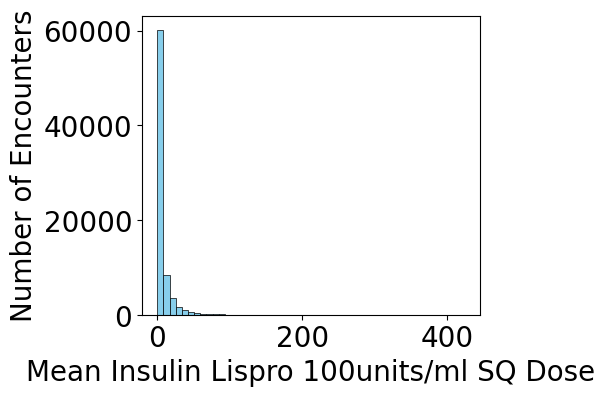

In [134]:
plt.figure(figsize=(5,4))
plt.hist(med_lab_static_PMH_admdx_nona['INSULIN_LISPRO_100_UNITS_ML_SOLN'], edgecolor='black', linewidth=0.5, color='skyblue', bins=50)
plt.ylabel("Number of Encounters", fontsize=20)
plt.xlabel("Mean Insulin Lispro 100units/ml SQ Dose", fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.tight_layout()
#plt.ylim(0,40000)
plt.savefig('figures/hist_prelog.svg')
plt.show()

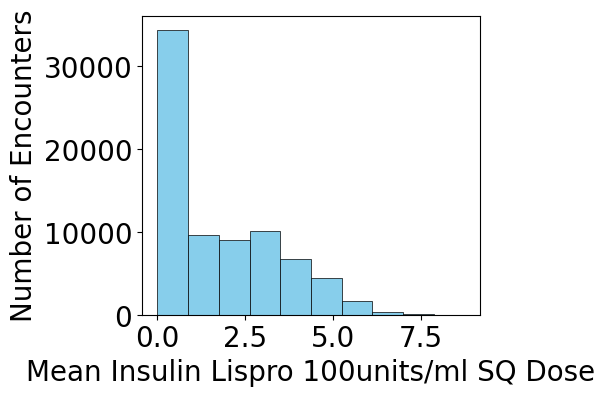

In [135]:
plt.figure(figsize=(5,4))
plt.hist(med_lab_static_PMH_admdx_log_nona['INSULIN_LISPRO_100_UNITS_ML_SOLN'], edgecolor='black', linewidth=0.5, color='skyblue')
plt.ylabel("Number of Encounters", fontsize=20)
plt.xlabel("Mean Insulin Lispro 100units/ml SQ Dose", fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.tight_layout()
#plt.ylim(0,40000)
plt.savefig('figures/hist_log.svg')
plt.show()

In [136]:
admin_counts=med_lab_static_PMH_admdx_log_nona.iloc[:,1:509][med_lab_static_PMH_admdx_log_nona.iloc[:,1:509]>0].count(axis=0).sort_values(ascending=False).reset_index()

In [137]:
new_column_names = ['Medication', 'Admins']

# Replace column names
admin_counts.columns = new_column_names

In [138]:
admin_counts['percent']=(admin_counts['Admins']/admin_counts['Admins'].sum())*100

In [139]:
admin_counts=admin_counts.iloc[0:10,:]

In [140]:
admin_counts

,Medication,Admins,percent
0,INSULIN_LISPRO_100_UNITS_ML_SOLN,41890,4.559267
1,DOCUSATE_SODIUM_100_MG_PO_CAPS,30273,3.294884
2,HEPARIN__PORCINE___5000_UNITS_ML_IJ_SOLN,27903,3.036936
3,SODIUM_CHLORIDE_0_9____FLUSH__IJ_SYRG,24314,2.646312
4,PANTOPRAZOLE_40_MG_PO_TBEC,17913,1.949634
5,INSULIN_GLARGINE_100_UNITS_ML,15958,1.736853
6,INSULIN_REGULAR_HUMAN_100_UNITS_ML_IJ_SOLN,14892,1.620831
7,SODIUM_CHLORIDE_0_9___IV_SOLP,14354,1.562276
8,ONDANSETRON_HCL__PF__4_MG_2_ML_IJ_SOLN,11631,1.265907
9,ACETAMINOPHEN__325_MG_PO_TABS,11367,1.237173


In [141]:
categories=['Insulin Lispro 100units/ml SQ','Docusate Sodium 100mg PO Caps','Heparin Porcine 5000units/ml Inj',
            'NaCl 0.9% Flush Inj Syringe', 'Pantoprazole 40mg EC PO Tabs','Insulin Glargine 100units/ml SQ',
            'Insulin Regular 100units/ml SQ','NaCl 0.9% IV','Ondansetron HCl PF 4mg/2ml Inj',
           'Acetaminophen 325mg PO Tabs']

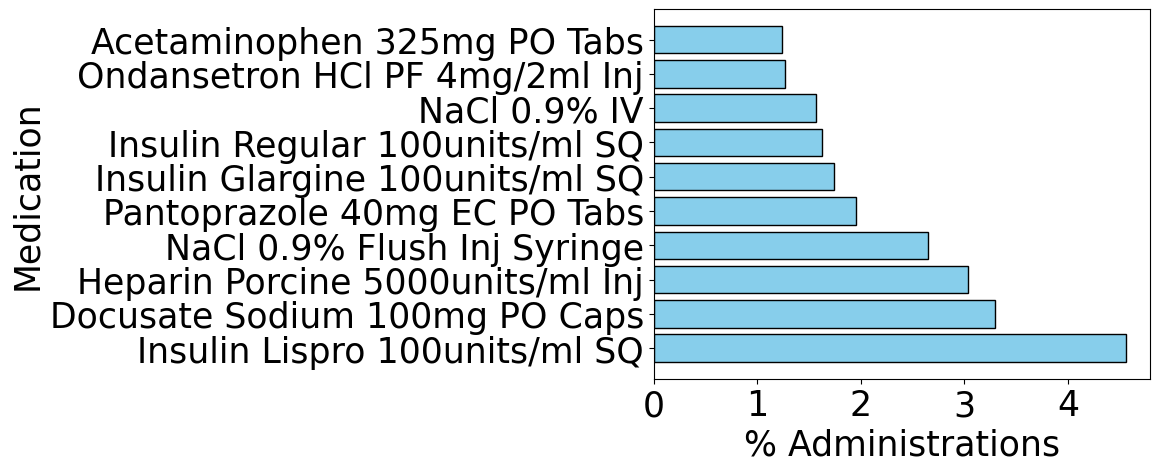

In [142]:
bars=plt.barh(categories,admin_counts['percent'],color='skyblue', edgecolor='black')
plt.ylabel('Medication', fontsize=25)
plt.xlabel('% Administrations', fontsize=25)

# Customize the ticks
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('figures/barplot.svg',bbox_inches='tight')
plt.show()

In [143]:
admit_dx=med_lab_static_PMH_admdx_log_nona.iloc[:,539:547][med_lab_static_PMH_admdx_log_nona.iloc[:,539:547]>0].count(axis=0).sort_values(ascending=False).reset_index()

In [144]:
new_column_names = ['Admit_dx', 'Counts']

# Replace column names
admit_dx.columns = new_column_names

In [145]:
admit_dx['percent']=(admit_dx['Counts']/admit_dx['Counts'].sum())*100

In [146]:
admit_names=['Pain','ESRD','Sepsis','Altered Mental Status','AKI','N/V',
             'CHF','GIB']

In [147]:
admit_dx['Admit_dx']=admit_names

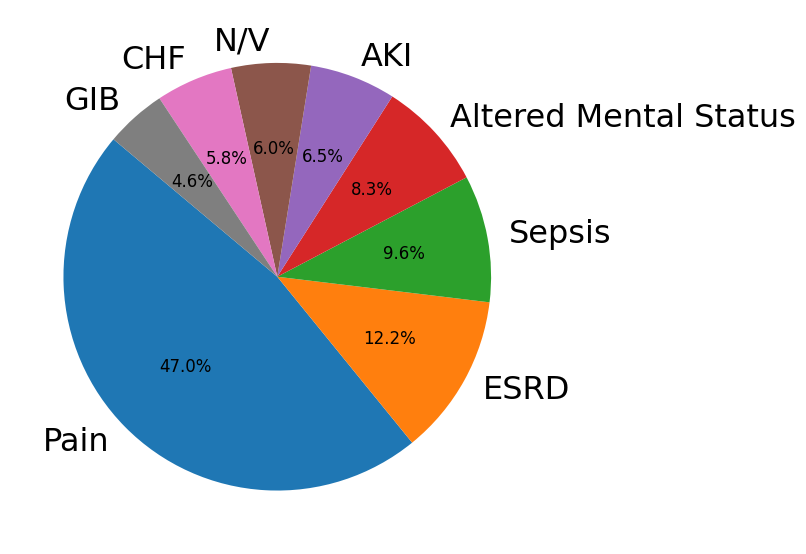

In [148]:
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(admit_dx['percent'],labels=admit_dx['Admit_dx'],autopct='%1.1f%%', startangle=140)

# Customize inside labels
plt.setp(autotexts, size=12)  # Inside label font size

# Customize outside labels
plt.setp(texts, size=23)  # Outside label font size
plt.tight_layout()
plt.savefig('figures/piechart.svg')
plt.show()

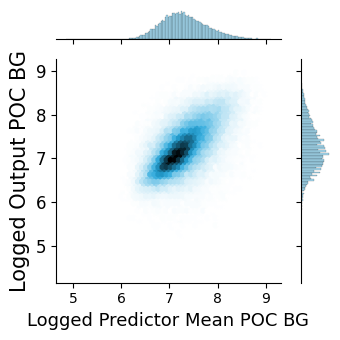

In [151]:
sns.jointplot(color='skyblue',height=3.5, x="GLUCOSE_POC_mean", y="ORD_VALUE", data=med_lab_static_PMH_admdx_log_nona, kind='hex')
plt.ylabel("Logged Output POC BG", fontsize=15)
plt.xlabel("Logged Predictor Mean POC BG", fontsize=13)
#ax.set_title("Optimized Lasso model")
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=12)
plt.tight_layout()
plt.savefig('figures/jointplot.svg')
plt.show()

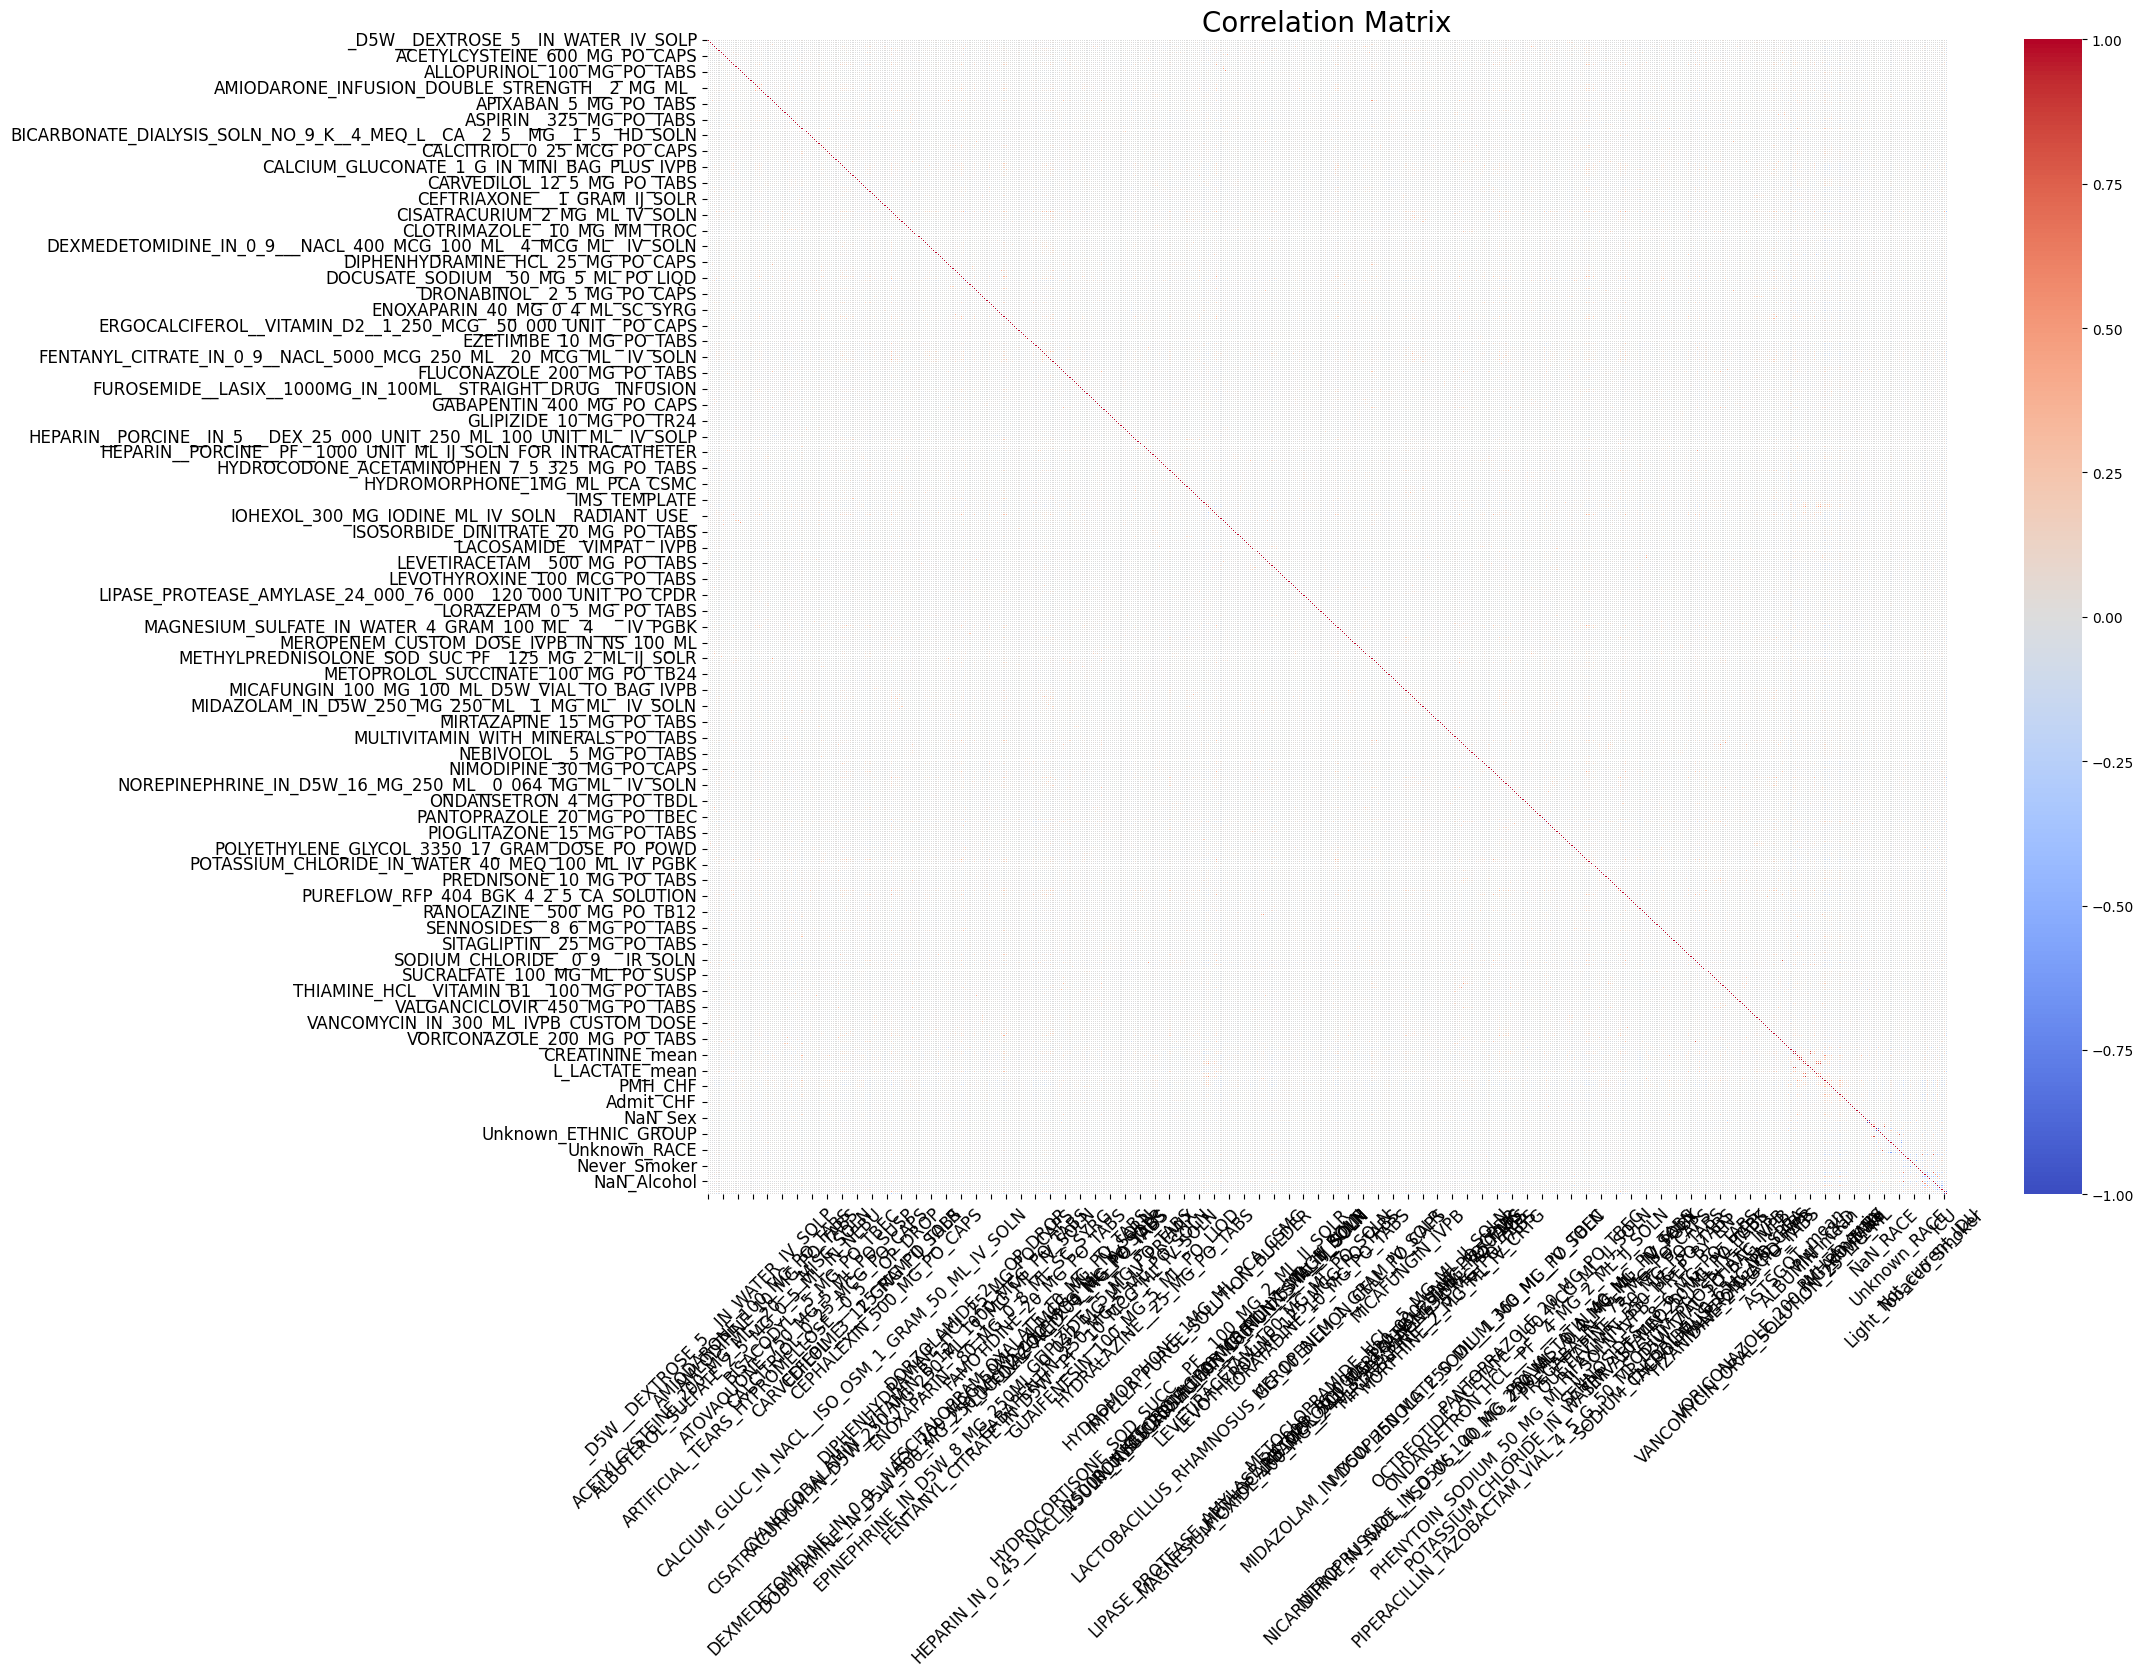

In [152]:
corr_matrix = X.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))  # Adjust the figure size as needed

# Draw the heatmap with the correlation matrix
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)

# Add titles and labels
plt.title('Correlation Matrix', fontsize=20)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

In [154]:
X_train.shape

(60985, 583)

In [155]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [156]:
X_train.shape

(48788, 583)

In [157]:
X_val.shape

(12197, 583)

In [158]:
# Define a list of alphas to test  
alphas = np.logspace(-4, 1, 10)  # 10 values from 10^-4 to 10^1  
  
# Create and fit the LassoCV model  
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)  # Using 5-fold cross-validation  
lasso_cv.fit(X_train, y_train)  
  
# The best alpha value found  
best_alpha = lasso_cv.alpha_  
print(f'The optimal alpha value found: {best_alpha}')  

The optimal alpha value found: 0.001291549665014884


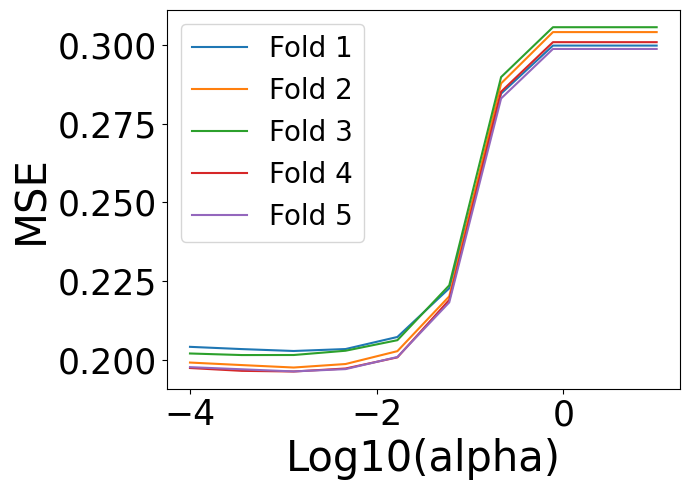

In [159]:
# Extract the alphas and MSEs
alphas = lasso_cv.alphas_
mse_path = lasso_cv.mse_path_

# Plot MSE vs log(alpha) for each fold
plt.figure(figsize=(7,5))
for i in range(mse_path.shape[1]):
    plt.plot(np.log10(alphas), mse_path[:, i], label=f'Fold {i+1}')
    
plt.xlabel('Log10(alpha)', fontsize=30)
plt.ylabel('MSE', fontsize=30)
plt.tick_params(axis='y', labelsize=25)  
plt.tick_params(axis='x', labelsize=25)  
plt.tight_layout()
#plt.title('MSE vs log(alpha) for each fold')
plt.legend(fontsize=20)
plt.savefig('figures/MSEvalpha.svg', dpi=300)

In [160]:
# Now you can use lasso_cv to predict on test data or analyze the model further  
y_pred = lasso_cv.predict(X_val)  
  
# Evaluate performance, for example, using the R^2 score  
r2_lasso = lasso_cv.score(X_val, y_val)  
print(f'R^2 score on test data: {r2_lasso}')  

R^2 score on test data: 0.35476914093926737


In [161]:
from sklearn.metrics import mean_squared_error
# Calculate the Mean Squared Error (MSE)
mean_squared_error(y_val, y_pred)

0.19742726353800552

In [162]:
# Calculate the Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_val, y_pred)
np.sqrt(mse)

0.44432787841638466

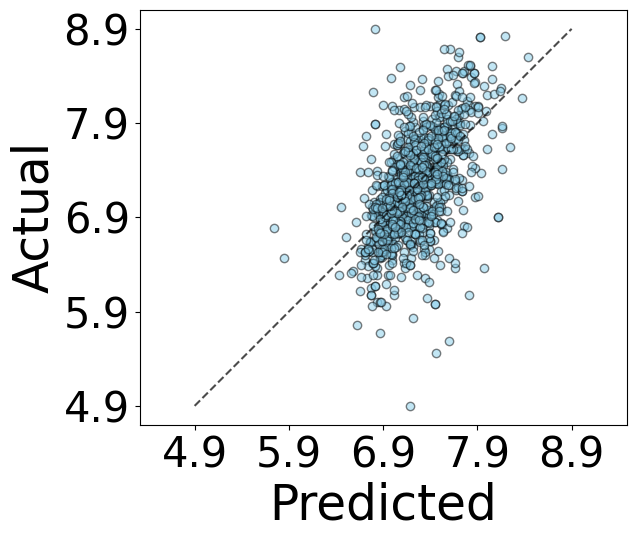

In [163]:
from matplotlib.ticker import FormatStrFormatter
_, ax = plt.subplots(figsize=(7,5.5))
display = PredictionErrorDisplay.from_predictions(
    y_val, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"color": "skyblue", "edgecolor": "black", "alpha": 0.5}
)
#ax.set_title("Optimized Lasso model")
plt.xlabel('Predicted', fontsize=35)
plt.ylabel('Actual', fontsize=35)
plt.tick_params(axis='y', labelsize=30)  
plt.tick_params(axis='x', labelsize=30)  
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig('figures/lasso_actual_vs_predicted.svg', dpi=300,bbox_inches='tight')

In [164]:
stats.spearmanr(y_val, y_pred)

SignificanceResult(statistic=0.6046742205339466, pvalue=0.0)

In [165]:
sorted_features_cleaned=['Mean POC BG',
                         'Mean Random BG',
                         'T2DM',
                         'Last POC BG',
                         'BMI',
                         'Insulin Aspart 100units/ml',
                         'Dexamethasone 4mg/ml',
                         'Sodium Bicarbonate 8.4% IV',
                         'Black or African American',
                         'Insulin Regular 100unit/100ml IV',
                         'Lidocaine 10mg/ml',    
                         'Age',
                         'Insulin Lispro 100units/ml',
                         'Mean L-Lactate',
                         'Mean Creatinine',
                         'Methylprednisolone Sodium Succinate 125mg/2ml',
                         'Asian',
                         'Prednisone 20mg tabs',
                         'Methylprednisolone Sodium Succinate 40mg/ml',
                         'Dexamethasone 4mg tabs']                

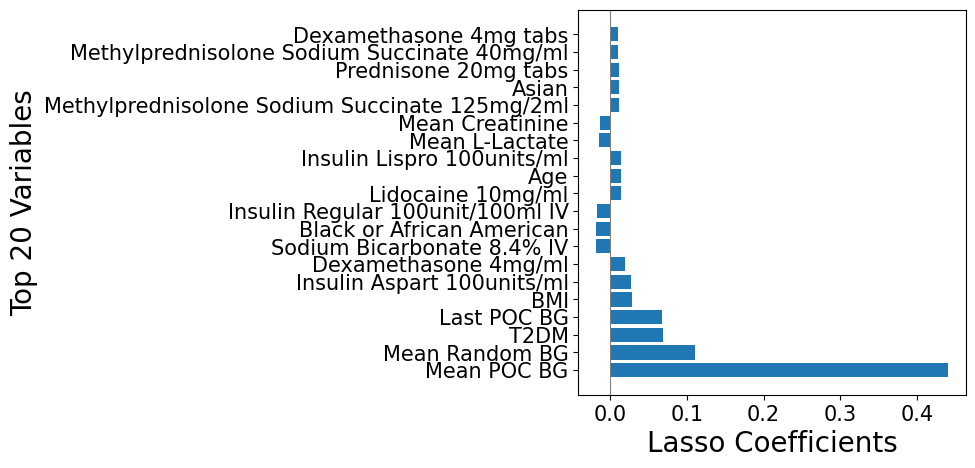

In [166]:
# Get the coefficients from the model  
coefficients = lasso_cv.coef_  
  
# Pair feature names with their corresponding coefficients  
feature_coefficients = list(zip(X_train.columns, coefficients))  
  
# Sort features by the absolute values of their coefficients in descending order  
feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)  
  
# Separate the feature names and their corresponding coefficients for plotting  
sorted_features, sorted_coefficients = zip(*feature_coefficients)  
  
# Plotting the ranked coefficients with features on the y-axis  
fig, ax = plt.subplots(figsize=(5,5))  
ax.barh(sorted_features_cleaned, sorted_coefficients[0:20])  
  
# Draw a horizontal line at zero  
ax.axvline(0, color='grey', linewidth=0.8)  

plt.xlabel('Lasso Coefficients', fontsize=20)
plt.ylabel('Top 20 Variables', fontsize=20)
plt.tick_params(axis='both', labelsize=15)  
#plt.tight_layout()
plt.savefig('figures/ranked_coeffs_lasso.svg', dpi=300,bbox_inches='tight')
plt.show()  

In [167]:
stats.spearmanr(y_val, y_pred)

SignificanceResult(statistic=0.6046742205339466, pvalue=0.0)

In [168]:
#pip install -U scikit-learn

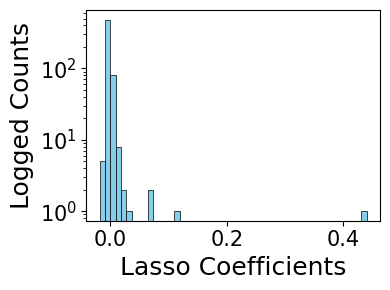

In [169]:
plt.figure(figsize=(4,3))
plt.hist(coefficients,bins=50, log=True,color='skyblue', edgecolor='black', linewidth=0.5)
plt.xlabel('Lasso Coefficients', fontsize=18)
plt.ylabel('Logged Counts', fontsize=18)
plt.tick_params(axis='both', labelsize=15)  
plt.tight_layout()
plt.savefig('figures/lasso_coeff_hist.svg', dpi=300)
plt.show()  

In [170]:
lasso_cv.alpha_

0.001291549665014884

In [171]:
# Define cross-validation strategy  
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)  
  
# Perform cross-validation  
cv_model = cross_validate(  
    Lasso(alpha=lasso_cv.alpha_, max_iter=10000, random_state=42),  
    X_train, y_train,
    cv=cv,  
    return_estimator=True,  
    n_jobs=-1,  
)  

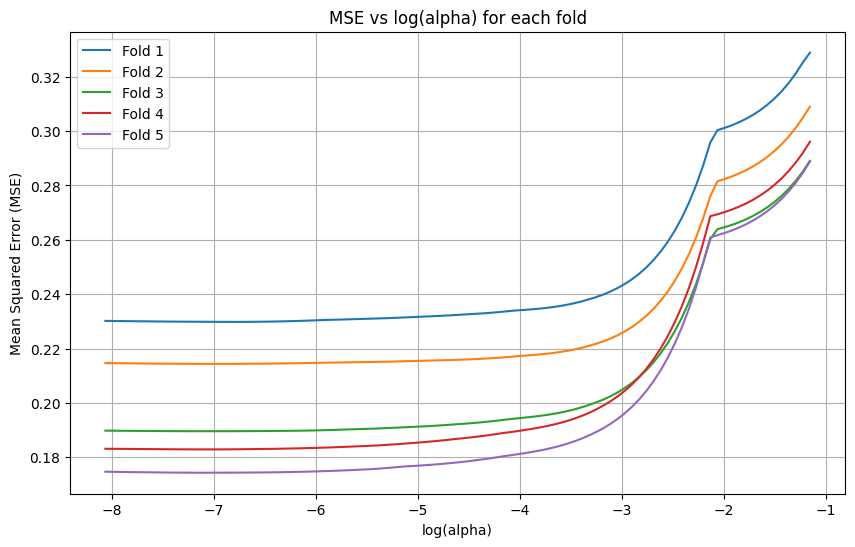

In [172]:
lasso_cv = LassoCV(cv=5, random_state=42)

# Fit the LassoCV model
lasso_cv.fit(X, y)

# Extract the alphas and MSEs
alphas = lasso_cv.alphas_
mse_path = lasso_cv.mse_path_

# Plot MSE vs log(alpha) for each fold
plt.figure(figsize=(10, 6))
for i in range(mse_path.shape[1]):
    plt.plot(np.log(alphas), mse_path[:, i], label=f'Fold {i+1}')
    
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs log(alpha) for each fold')
plt.legend()
plt.grid(True)
plt.show()

In [173]:
# Extract the coefficients from each fold and repeat  
coefs = [est.coef_ for est in cv_model['estimator']]  
coefs_df = pd.DataFrame(coefs, columns=X_train.columns) 

# Calculate the mean absolute coefficient value for each feature  
mean_coefs = coefs_df.abs().mean().sort_values(ascending=False)  
  
# Select the names of the top 25 features with the highest mean coefficient value  
top_25_feature_names = mean_coefs.head(25).index  
  
# Subset the original DataFrame to include only the top 25 features  
top_25_coefs_df = coefs_df[top_25_feature_names]  

In [174]:
mean_coefs_df=pd.DataFrame(mean_coefs)
mean_coefs_df.columns = ['mean absolute value coefficient']

In [176]:
mean_coefs_df.to_csv('mean_abs_coefs_df.csv')

In [ ]:
top_25_coefs_df.columns

Index(['GLUCOSE_POC_mean', 'GLUCOSERANDOM_mean', 'PMH_T2DM',
       'GLUCOSE_POC_last', 'BMI', 'INSULIN_ASPART_U_100_100_UNITS_ML_SC_SOLN',
       'DEXAMETHASONE_SODIUM_PHOSPHATE__4_MG_ML_IJ_SOLN',
       'SODIUM_BICARBONATE_8_4____1_MEQ_ML__IV_SYRG',
       'INSULIN_REGULAR_IN_0_9__NACL_100_UNITS_100_ML__ADULT_',
       'Black_or_African_American', 'AGE',
       'LIDOCAINE__PF__10_MG_ML__1____IJ_SOLN',
       'INSULIN_LISPRO_100_UNITS_ML_SOLN', 'L_LACTATE_mean', 'CREATININE_mean',
       'METHYLPREDNISOLONE_SOD_SUC_PF__125_MG_2_ML_IJ_SOLR', 'Asian',
       'PREDNISONE_20_MG_PO_TABS',
       'METHYLPREDNISOLONE_SOD_SUC_PF__40_MG_ML_IJ_SOLR',
       'DEXAMETHASONE__4_MG_PO_TABS', 'PREDNISONE__5_MG_PO_TABS',
       'METHYLPREDNISOLONE_SODIUM_SUCC_IVPB', 'BISACODYL__5_MG_PO_TBEC',
       'GLUCOSE_POC_max', 'PRISMASATE_BK_0_3_5_CA_'],
      dtype='object')

In [178]:
top25coef_names=['Mean POC BG', 'Mean Random BG','T2DM',
                              'Last POC BG','BMI', 'Insulin Aspart 100units/ml SQ',
                              'Dexamethasone Sodium Phosphate 4mg/ml Inj',
                              'Sodium Bicarbonate 8.4% IV Syr',
                              'Insulin Regular in 0.9% NaCl 100units/100ml IV',
                              'Black/African American','Age','Lidocaine PF 10mg/ml Inj',
                              'Insulin Lispro 100units/ml SQ',
                              'Mean L-Lactate',
                              'Mean Creatinine',
                              'Methylprednisolone Sodium Succinate PF 125mg/2ml Inj',
                              'Asian',
                              'Prednisone 20mg PO Tabs',
                              'Methylprednisolone Sodium Succinate PF 40mg/ml Inj',
                              'Dexamethasone 4mg PO Tabs',
                              'Prednisone 5mg PO Tabs',
                              'Methylprednisolone Sodium Succinate IVPB',
                              'Bisacodyl 5mg PO EC Tabs',
                              'Maximum POC BG',
                              'Prismasate BK 0/3.5 CA+']

In [179]:
top_25_coefs_df.columns=top25coef_names

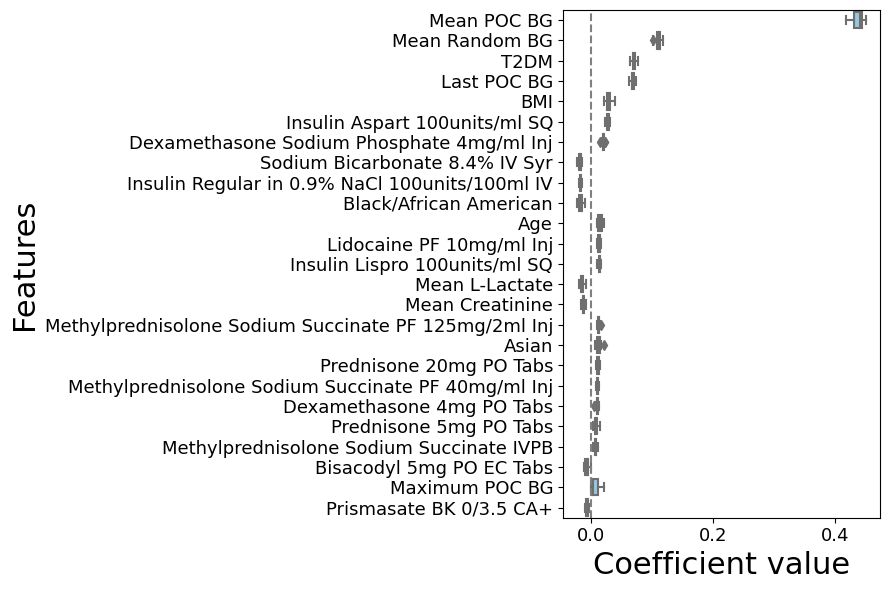

In [180]:
# Plot the coefficient variability for the top 25 features using a boxplot  
plt.figure(figsize=(9, 6))  
sns.boxplot(data=top_25_coefs_df, orient="h", color="skyblue")  
plt.axvline(x=0, color="grey", linestyle="--")  
plt.xlabel("Coefficient value", fontsize=22)  
plt.ylabel("Features",fontsize=22)  
#plt.title("Coefficient Variability Sorted by Mean", fontsize=20)  
plt.tick_params(axis='both', labelsize=13) 
plt.tight_layout()
plt.savefig('figures/coeff_var_lasso.svg', dpi=300)
plt.show()  

In [295]:
#select top 50 features 
top_50_feature_names = mean_coefs.head(50).index  

### checking residual errors

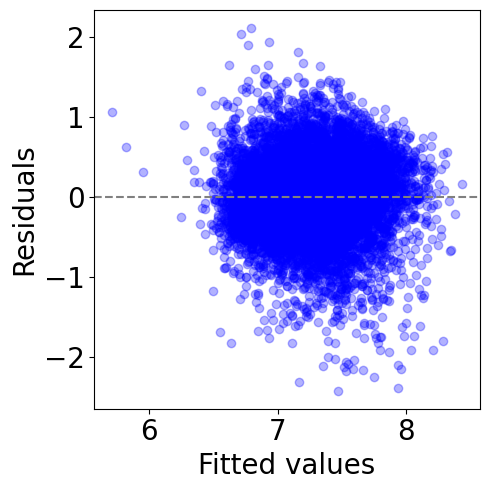

In [182]:
# Make predictions on the test data
# Calculate the residuals (difference between true and predicted values)
residuals = y_val - y_pred

# Plot residuals vs. fitted values
plt.figure(figsize=(5, 5))
plt.scatter(y_pred, residuals, alpha=0.3, color='blue')
plt.axhline(y=0, color='grey', linestyle='--')
plt.xlabel('Fitted values', fontsize=20)
plt.ylabel('Residuals', fontsize=20)
#plt.title('Residuals vs. Fitted values', fontsize=16)
plt.grid(False)
plt.tick_params(axis='both', labelsize=20) 
plt.tight_layout()
plt.savefig('figures/RVF_lasso.svg', dpi=300)
plt.show()  

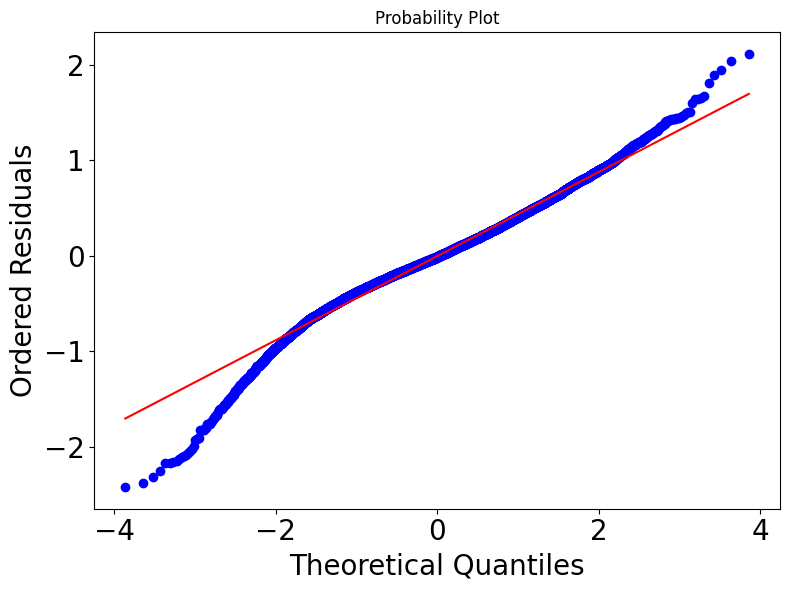

In [183]:
# Plot Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
#plt.title('Q-Q plot of Residuals', fontsize=16)
plt.xlabel('Theoretical Quantiles', fontsize=20)
plt.ylabel('Ordered Residuals', fontsize=20)
plt.tick_params(axis='both', labelsize=20) 
plt.grid(False)
plt.tight_layout()
plt.savefig('figures/QQ_lasso.svg', dpi=300)
plt.show()

### Mixed Effects Model

In [296]:
top_50_feature_names=top_50_feature_names.to_list()

In [297]:
top_50_feature_names.append('MRN')

In [298]:
top_50_feature_names.append('ORD_VALUE')

In [299]:
inputs_lasso=med_lab_static_PMH_admdx_log_nona[top_50_feature_names]

In [188]:
X_train, X_test, y_train, y_test = train_test_split(inputs_lasso, y, 
                                                    test_size=0.2, random_state=42)

In [189]:
','.join(X_train.columns.to_list()).replace(",", " + ")

'GLUCOSE_POC_mean + GLUCOSERANDOM_mean + PMH_T2DM + GLUCOSE_POC_last + BMI + INSULIN_ASPART_U_100_100_UNITS_ML_SC_SOLN + DEXAMETHASONE_SODIUM_PHOSPHATE__4_MG_ML_IJ_SOLN + SODIUM_BICARBONATE_8_4____1_MEQ_ML__IV_SYRG + INSULIN_REGULAR_IN_0_9__NACL_100_UNITS_100_ML__ADULT_ + Black_or_African_American + AGE + LIDOCAINE__PF__10_MG_ML__1____IJ_SOLN + INSULIN_LISPRO_100_UNITS_ML_SOLN + L_LACTATE_mean + CREATININE_mean + METHYLPREDNISOLONE_SOD_SUC_PF__125_MG_2_ML_IJ_SOLR + Asian + PREDNISONE_20_MG_PO_TABS + METHYLPREDNISOLONE_SOD_SUC_PF__40_MG_ML_IJ_SOLR + DEXAMETHASONE__4_MG_PO_TABS + PREDNISONE__5_MG_PO_TABS + METHYLPREDNISOLONE_SODIUM_SUCC_IVPB + BISACODYL__5_MG_PO_TBEC + GLUCOSE_POC_max + PRISMASATE_BK_0_3_5_CA_ + METFORMIN__500_MG_PO_TABS + WATER_FOR_IRRIGATION__STERILE_IR_SOLN + KETOROLAC_30_MG_ML__1_ML__IJ_SOLN + LORAZEPAM_2_MG_ML_IJ_SOLN + C_REACTIVEPROTEIN_mean + NOREPINEPHRINE_IN_0_9__NACL_16_MG_250_ML__0_064_MG_ML__IV_SOLN + NATEGLINIDE_120_MG_PO_TABS + FAT_EMULSION_20___SMOFLIPID__

In [190]:
md = smf.mixedlm("ORD_VALUE ~GLUCOSE_POC_mean + GLUCOSERANDOM_mean + PMH_T2DM + GLUCOSE_POC_last + BMI + INSULIN_ASPART_U_100_100_UNITS_ML_SC_SOLN + DEXAMETHASONE_SODIUM_PHOSPHATE__4_MG_ML_IJ_SOLN + SODIUM_BICARBONATE_8_4____1_MEQ_ML__IV_SYRG + INSULIN_REGULAR_IN_0_9__NACL_100_UNITS_100_ML__ADULT_ + Black_or_African_American + AGE + LIDOCAINE__PF__10_MG_ML__1____IJ_SOLN + INSULIN_LISPRO_100_UNITS_ML_SOLN + L_LACTATE_mean + CREATININE_mean + METHYLPREDNISOLONE_SOD_SUC_PF__125_MG_2_ML_IJ_SOLR + Asian + PREDNISONE_20_MG_PO_TABS + METHYLPREDNISOLONE_SOD_SUC_PF__40_MG_ML_IJ_SOLR + DEXAMETHASONE__4_MG_PO_TABS + PREDNISONE__5_MG_PO_TABS + METHYLPREDNISOLONE_SODIUM_SUCC_IVPB + BISACODYL__5_MG_PO_TBEC + GLUCOSE_POC_max + PRISMASATE_BK_0_3_5_CA_ + METFORMIN__500_MG_PO_TABS + WATER_FOR_IRRIGATION__STERILE_IR_SOLN + KETOROLAC_30_MG_ML__1_ML__IJ_SOLN + LORAZEPAM_2_MG_ML_IJ_SOLN + C_REACTIVEPROTEIN_mean + NOREPINEPHRINE_IN_0_9__NACL_16_MG_250_ML__0_064_MG_ML__IV_SOLN + NATEGLINIDE_120_MG_PO_TABS + FAT_EMULSION_20___SMOFLIPID__ADULT + QUETIAPINE__25_MG_PO_TABS + NOREPINEPHRINE_IN_0_9__NACL_8_MG_250_ML__0_032_MG_ML__IV_SOLN + METFORMIN_1000_MG_PO_TABS + PMH_CHF + FAT_EMULSION_20___IV_EMUL + RIFAXIMIN_550_MG_PO_TABS + FENTANYL_CITRATE_IN_D5W_5000_MCG_250_ML__20_MCG_ML__IV_SOLN + CARVEDILOL_25_MG_PO_TABS + NOREPINEPHRINE__LEVOPHED__0_032MG_ML__8_MG_IN_D5W_250_ML + FLUCONAZOLE_100_MG_PO_TABS + HEPARIN__PORCINE__PF___100_UNITS_ML_IV_SYRG + LIPASE_PROTEASE_AMYLASE_24_000_76_000__120_000_UNIT_PO_CPDR + IOHEXOL_350_MG_IODINE_ML_IV_SOLN + LACTATED_RINGERS_IV_SOLP + LEVETIRACETAM_100_MG_ML_PO_SOLN + EPINEPHRINE_IN_D5W_8_MG_250ML__0_032_MG_ML_IV_PREMIX + CEFAZOLIN___1_GRAM_IJ_SOLR",
                 X_train, groups=X_train["MRN"])               

In [191]:
mdf = md.fit()
print(mdf.summary())

C:\Users\momenzadeha\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                                  Mixed Linear Model Regression Results
Model:                             MixedLM                 Dependent Variable:                 ORD_VALUE  
No. Observations:                  60985                   Method:                             REML       
No. Groups:                        38251                   Scale:                              0.1949     
Min. group size:                   1                       Log-Likelihood:                     -37377.6647
Max. group size:                   46                      Converged:                          Yes        
Mean group size:                   1.6                                                                    
----------------------------------------------------------------------------------------------------------
                                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------

In [192]:
y_pred = mdf.predict(X_test)

In [193]:
# Assuming y_test and y_pred are numpy arrays or pandas Series containing the true and predicted target values, respectively
r_squared = r2_score(y_test, y_pred)

# Print or use the calculated R-squared value
print("R-squared:", r_squared)

R-squared: 0.3472039014137486


In [194]:
residuals = y_test - y_pred

In [195]:
stats.pearsonr(y_test, y_pred)

PearsonRResult(statistic=0.5893189778547276, pvalue=0.0)

In [196]:
stats.spearmanr(y_test, y_pred)

SignificanceResult(statistic=0.5961800921189341, pvalue=0.0)

In [197]:
# Calculate the Mean Squared Error (MSE)
mean_squared_error(y_test, y_pred)

0.19663675508133444

In [198]:
# Calculate the Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.443437430852803

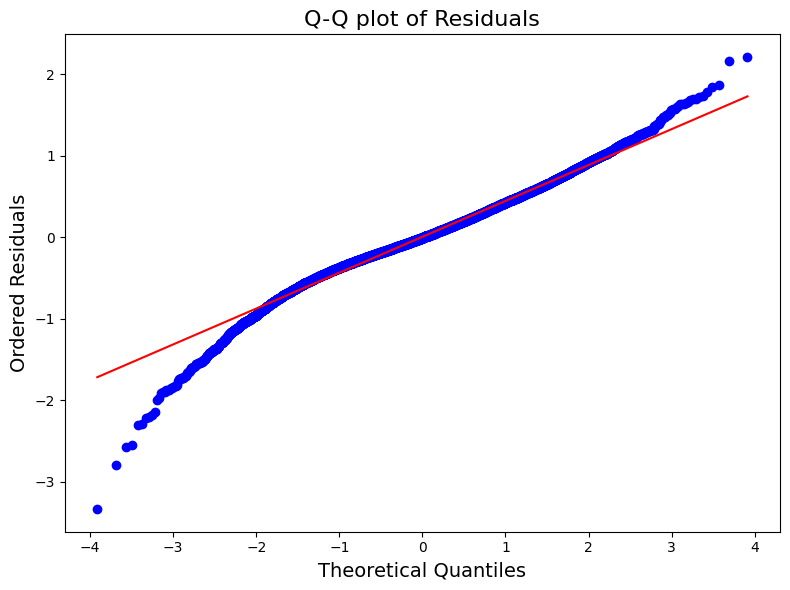

In [199]:
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot of Residuals', fontsize=16)
plt.xlabel('Theoretical Quantiles', fontsize=14)
plt.ylabel('Ordered Residuals', fontsize=14)
#plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_51360\2140000699.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(mdf.resid, hist = False, kde_kws = {"fill" : True, "lw": 1}, fit = stats.norm)


Text(0.5, 0, 'Residuals')

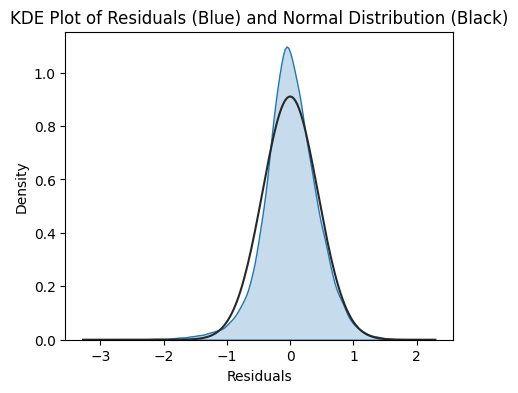

In [200]:
#check for normality of the residuals
fig = plt.figure(figsize = (5,4))
ax = sns.distplot(mdf.resid, hist = False, kde_kws = {"fill" : True, "lw": 1}, fit = stats.norm)
ax.set_title("KDE Plot of Residuals (Blue) and Normal Distribution (Black)")
ax.set_xlabel("Residuals")

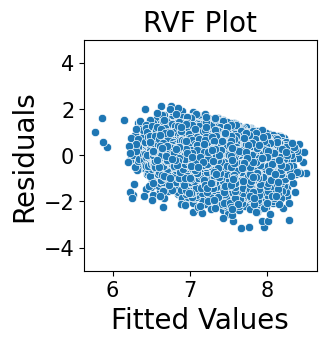

In [201]:
fig = plt.figure(figsize = (3,3))

ax = sns.scatterplot(y = mdf.resid, x = mdf.fittedvalues)

ax.set_title("RVF Plot",fontsize=20)
ax.set_xlabel("Fitted Values",fontsize=20)
ax.set_ylabel("Residuals",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-5,5)
plt.show()

In [202]:
adj_p = statsmodels.stats.multitest.multipletests(pvals=mdf.pvalues.to_list(), alpha=0.01, method="fdr_bh")

In [203]:
summary_frame = mdf.summary().tables[1]

In [204]:
summary_frame.columns

Index(['Coef.', 'Std.Err.', 'z', 'P>|z|', '[0.025', '0.975]'], dtype='object')

In [205]:
dict = {'variable': mdf.pvalues.index, 'unadjusted_p_value':mdf.pvalues.to_list(),
        'adjusted_p_value':adj_p[1],'coefficient': summary_frame['Coef.'], 
        'standard error':summary_frame['Std.Err.'],'95CI_lower':summary_frame['[0.025'],
        '95CI_upper':summary_frame['0.975]']} 
    
df = pd.DataFrame(dict).set_index('variable')

In [206]:
df[df['adjusted_p_value']>=0.01].sort_values(by='adjusted_p_value').shape

(11, 6)

In [207]:
df[df['adjusted_p_value']>=0.01].sort_values(by='adjusted_p_value').to_csv('notsig.csv')

In [208]:
df[df['adjusted_p_value']<0.01].sort_values(by='adjusted_p_value').reset_index().shape

(41, 7)

In [209]:
df.to_csv('24hLB_MELR_no_interaction.csv')

In [210]:
sig_24h=df[df['adjusted_p_value']<0.01].sort_values(by='adjusted_p_value').reset_index().variable.to_list()

In [211]:
items_to_remove = {'Group Var','Intercept'}
sig_24h = [item for item in sig_24h if item not in items_to_remove]

In [293]:
sig_24h

['GLUCOSE_POC_mean',
 'GLUCOSERANDOM_mean',
 'PMH_T2DM',
 'GLUCOSE_POC_last',
 'INSULIN_REGULAR_IN_0_9__NACL_100_UNITS_100_ML__ADULT_',
 'INSULIN_LISPRO_100_UNITS_ML_SOLN',
 'WATER_FOR_IRRIGATION__STERILE_IR_SOLN',
 'INSULIN_ASPART_U_100_100_UNITS_ML_SC_SOLN',
 'DEXAMETHASONE_SODIUM_PHOSPHATE__4_MG_ML_IJ_SOLN',
 'BMI',
 'METHYLPREDNISOLONE_SOD_SUC_PF__40_MG_ML_IJ_SOLR',
 'METHYLPREDNISOLONE_SOD_SUC_PF__125_MG_2_ML_IJ_SOLR',
 'SODIUM_BICARBONATE_8_4____1_MEQ_ML__IV_SYRG',
 'AGE',
 'METFORMIN__500_MG_PO_TABS',
 'LIDOCAINE__PF__10_MG_ML__1____IJ_SOLN',
 'PREDNISONE_20_MG_PO_TABS',
 'L_LACTATE_mean',
 'Black_or_African_American',
 'METHYLPREDNISOLONE_SODIUM_SUCC_IVPB',
 'RIFAXIMIN_550_MG_PO_TABS',
 'METFORMIN_1000_MG_PO_TABS',
 'PREDNISONE__5_MG_PO_TABS',
 'HEPARIN__PORCINE__PF___100_UNITS_ML_IV_SYRG',
 'C_REACTIVEPROTEIN_mean',
 'DEXAMETHASONE__4_MG_PO_TABS',
 'KETOROLAC_30_MG_ML__1_ML__IJ_SOLN',
 'LORAZEPAM_2_MG_ML_IJ_SOLN',
 'LEVETIRACETAM_100_MG_ML_PO_SOLN',
 'FAT_EMULSION_20___IV_EMUL

In [212]:
sig_48h=[ 'GLUCOSE_POC_mean',
 'GLUCOSE_POC_last',
 'GLUCOSERANDOM_mean',
 'PMH_T2DM',
 'INSULIN_LISPRO_100_UNITS_ML_SOLN',
 'INSULIN_REGULAR_IN_0_9__NACL_100_UNITS_100_ML__ADULT_',
 'WATER_FOR_IRRIGATION__STERILE_IR_SOLN',
 'METFORMIN__500_MG_PO_TABS',
 'INSULIN_ASPART_U_100_100_UNITS_ML_SC_SOLN',
 'LIDOCAINE__PF__10_MG_ML__1____IJ_SOLN',
 'METFORMIN_1000_MG_PO_TABS',
 'METHYLPREDNISOLONE_SOD_SUC_PF__40_MG_ML_IJ_SOLR',
 'BMI',
 'Black_or_African_American',
 'DEXAMETHASONE_SODIUM_PHOSPHATE__4_MG_ML_IJ_SOLN',
 'AGE',
 'METHYLPREDNISOLONE_SOD_SUC_PF__125_MG_2_ML_IJ_SOLR',
 'RIFAXIMIN_550_MG_PO_TABS',
 'INSULIN_GLARGINE_100_UNITS_ML',
 'FAT_EMULSION_20___IV_EMUL',
 'INSULIN_REGULAR_HUMAN_100_UNITS_ML_IJ_SOLN',
 'PREDNISONE_20_MG_PO_TABS',
 'METHYLPREDNISOLONE_SODIUM_SUCC_IVPB',
 'PREDNISONE__5_MG_PO_TABS',
 'SODIUM_BICARBONATE_8_4____1_MEQ_ML__IV_SYRG',
 'L_LACTATE_mean',
 'ONDANSETRON_HCL__PF__4_MG_2_ML_IJ_SOLN',
 'POTASSIUM_CHLORIDE_20_MEQ_15_ML_PO_LIQD',
 'DEXAMETHASONE__4_MG_PO_TABS',
 'ATOVAQUONE_750_MG_5_ML_PO_SUSP',
 'LACTATED_RINGERS_IV_SOLP',
 'EPINEPHRINE_IN_D5W_8_MG_250ML__0_032_MG_ML_IV_PREMIX',
 'KETOROLAC_30_MG_ML__1_ML__IJ_SOLN',
 'PREDNISONE_10_MG_PO_TABS',
 'Asian',
 'NATEGLINIDE_120_MG_PO_TABS',
 'NOREPINEPHRINE_IN_0_9__NACL_16_MG_250_ML__0_064_MG_ML__IV_SOLN',
 'CREATININE_mean',
 'INSULIN_NPH_AND_REGULAR_HUMAN_100_UNIT_ML__70_30__SC',
 'LORAZEPAM_2_MG_ML_IJ_SOLN']

In [213]:
sig_12h=['GLUCOSERANDOM_mean',
 'PMH_T2DM',
 'GLUCOSE_POC_last',
 'INSULIN_REGULAR_IN_0_9__NACL_100_UNITS_100_ML__ADULT_',
 'PREDNISONE_20_MG_PO_TABS',
 'WATER_FOR_IRRIGATION__STERILE_IR_SOLN',
 'PREDNISONE__5_MG_PO_TABS',
 'GLUCOSE_POC_mean',
 'DEXAMETHASONE_SODIUM_PHOSPHATE__4_MG_ML_IJ_SOLN',
 'METHYLPREDNISOLONE_SOD_SUC_PF__40_MG_ML_IJ_SOLR',
 'METHYLPREDNISOLONE_SOD_SUC_PF__125_MG_2_ML_IJ_SOLR',
 'PREDNISONE_10_MG_PO_TABS',
 'SODIUM_CHLORIDE_0_9___IV_SOLP',
 'INSULIN_ASPART_U_100_100_UNITS_ML_SC_SOLN',
 'AGE',
 'GLUCOSE_POC_max',
 'INSULIN_LISPRO_100_UNITS_ML_SOLN',
 'FLUCONAZOLE_100_MG_PO_TABS',
 'DEXTROSE_50___IN_WATER__D50W__IV_SYRG',
 'RIFAXIMIN_550_MG_PO_TABS',
 'L_LACTATE_mean',
 'METFORMIN__500_MG_PO_TABS',
 'Asian',
 'DEXAMETHASONE__4_MG_PO_TABS',
 'METHYLPREDNISOLONE_SODIUM_SUCC_IVPB',
 'Black_or_African_American',
 'LIDOCAINE__PF__10_MG_ML__1____IJ_SOLN',
 'BMI',
 'HYDROCORTISONE_SOD_SUCC__PF__100_MG_2_ML_IJ_SOLR',
 'KETOROLAC_30_MG_ML__1_ML__IJ_SOLN',
 'CARVEDILOL_25_MG_PO_TABS',
 'SODIUM_BICARBONATE_8_4____1_MEQ_ML__IV_SYRG',
 'LORAZEPAM_2_MG_ML_IJ_SOLN',
 'Hispanic',
 'NOREPINEPHRINE__LEVOPHED__0_032MG_ML__8_MG_IN_D5W_250_ML',
 'Not_current_alcohol',
 'IOHEXOL_350_MG_IODINE_ML_IV_SOLN',
 'ROSUVASTATIN_20_MG_PO_TABS',
 'LOSARTAN__50_MG_PO_TABS',
 'MIDODRINE_10_MG_PO_TABS',
 'INSULIN_NPH_AND_REGULAR_HUMAN_100_UNIT_ML__70_30__SC',
 'MYCOPHENOLATE_SODIUM_360_MG_PO_TBEC',
 'C_REACTIVEPROTEIN_mean']

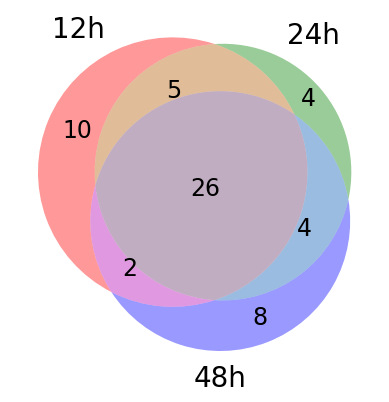

In [214]:
from matplotlib_venn import venn3
venn=venn3([set(sig_12h), set(sig_24h), set(sig_48h)], ('12h', '24h', '48h'), set_colors=('r', 'g', 'b'))
for text in venn.set_labels:
    if text:
        text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:
        text.set_fontsize(17)  # Set subset label font size
plt.savefig('figures/venn.svg', dpi=300)

In [215]:
unique_to_list1 = set(sig_12h) - (set(sig_24h) | set(sig_48h))
unique_to_list2 = set(sig_24h) - (set(sig_12h) | set(sig_48h))
unique_to_list3 = set(sig_48h) - (set(sig_12h) | set(sig_24h))

In [216]:
unique_to_list1

{'DEXTROSE_50___IN_WATER__D50W__IV_SYRG',
 'GLUCOSE_POC_max',
 'HYDROCORTISONE_SOD_SUCC__PF__100_MG_2_ML_IJ_SOLR',
 'Hispanic',
 'LOSARTAN__50_MG_PO_TABS',
 'MIDODRINE_10_MG_PO_TABS',
 'MYCOPHENOLATE_SODIUM_360_MG_PO_TBEC',
 'Not_current_alcohol',
 'ROSUVASTATIN_20_MG_PO_TABS',
 'SODIUM_CHLORIDE_0_9___IV_SOLP'}

In [217]:
unique_to_list2

{'FENTANYL_CITRATE_IN_D5W_5000_MCG_250_ML__20_MCG_ML__IV_SOLN',
 'HEPARIN__PORCINE__PF___100_UNITS_ML_IV_SYRG',
 'LEVETIRACETAM_100_MG_ML_PO_SOLN',
 'PRISMASATE_BK_0_3_5_CA_'}

In [218]:
unique_to_list3 

{'ATOVAQUONE_750_MG_5_ML_PO_SUSP',
 'EPINEPHRINE_IN_D5W_8_MG_250ML__0_032_MG_ML_IV_PREMIX',
 'INSULIN_GLARGINE_100_UNITS_ML',
 'INSULIN_REGULAR_HUMAN_100_UNITS_ML_IJ_SOLN',
 'LACTATED_RINGERS_IV_SOLP',
 'NOREPINEPHRINE_IN_0_9__NACL_16_MG_250_ML__0_064_MG_ML__IV_SOLN',
 'ONDANSETRON_HCL__PF__4_MG_2_ML_IJ_SOLN',
 'POTASSIUM_CHLORIDE_20_MEQ_15_ML_PO_LIQD'}

In [219]:
set(sig_12h).intersection(set(sig_24h)).intersection(set(sig_48h))

{'AGE',
 'Asian',
 'BMI',
 'Black_or_African_American',
 'DEXAMETHASONE_SODIUM_PHOSPHATE__4_MG_ML_IJ_SOLN',
 'DEXAMETHASONE__4_MG_PO_TABS',
 'GLUCOSERANDOM_mean',
 'GLUCOSE_POC_last',
 'GLUCOSE_POC_mean',
 'INSULIN_ASPART_U_100_100_UNITS_ML_SC_SOLN',
 'INSULIN_LISPRO_100_UNITS_ML_SOLN',
 'INSULIN_REGULAR_IN_0_9__NACL_100_UNITS_100_ML__ADULT_',
 'KETOROLAC_30_MG_ML__1_ML__IJ_SOLN',
 'LIDOCAINE__PF__10_MG_ML__1____IJ_SOLN',
 'LORAZEPAM_2_MG_ML_IJ_SOLN',
 'L_LACTATE_mean',
 'METFORMIN__500_MG_PO_TABS',
 'METHYLPREDNISOLONE_SODIUM_SUCC_IVPB',
 'METHYLPREDNISOLONE_SOD_SUC_PF__125_MG_2_ML_IJ_SOLR',
 'METHYLPREDNISOLONE_SOD_SUC_PF__40_MG_ML_IJ_SOLR',
 'PMH_T2DM',
 'PREDNISONE_20_MG_PO_TABS',
 'PREDNISONE__5_MG_PO_TABS',
 'RIFAXIMIN_550_MG_PO_TABS',
 'SODIUM_BICARBONATE_8_4____1_MEQ_ML__IV_SYRG',
 'WATER_FOR_IRRIGATION__STERILE_IR_SOLN'}

#### now add interaction terms

In [300]:
top_50_feature_names.append('Admit_Sepsis')

In [301]:
top_50_feature_names.append('PMH_CKD')

In [302]:
top_50_feature_names.append('PMH_Liver_failure')

In [303]:
top_50_feature_names.append('Admit_Pain')

In [304]:
inputs_lasso=med_lab_static_PMH_admdx_log_nona[top_50_feature_names]

In [305]:
X_train, X_test, y_train, y_test = train_test_split(inputs_lasso, y, 
                                                    test_size=0.2, random_state=42)

In [306]:
','.join(X_train.columns.to_list()).replace(",", " + ")

'GLUCOSE_POC_mean + GLUCOSERANDOM_mean + PMH_T2DM + GLUCOSE_POC_last + BMI + INSULIN_ASPART_U_100_100_UNITS_ML_SC_SOLN + DEXAMETHASONE_SODIUM_PHOSPHATE__4_MG_ML_IJ_SOLN + SODIUM_BICARBONATE_8_4____1_MEQ_ML__IV_SYRG + INSULIN_REGULAR_IN_0_9__NACL_100_UNITS_100_ML__ADULT_ + Black_or_African_American + AGE + LIDOCAINE__PF__10_MG_ML__1____IJ_SOLN + INSULIN_LISPRO_100_UNITS_ML_SOLN + L_LACTATE_mean + CREATININE_mean + METHYLPREDNISOLONE_SOD_SUC_PF__125_MG_2_ML_IJ_SOLR + Asian + PREDNISONE_20_MG_PO_TABS + METHYLPREDNISOLONE_SOD_SUC_PF__40_MG_ML_IJ_SOLR + DEXAMETHASONE__4_MG_PO_TABS + PREDNISONE__5_MG_PO_TABS + METHYLPREDNISOLONE_SODIUM_SUCC_IVPB + BISACODYL__5_MG_PO_TBEC + GLUCOSE_POC_max + PRISMASATE_BK_0_3_5_CA_ + METFORMIN__500_MG_PO_TABS + WATER_FOR_IRRIGATION__STERILE_IR_SOLN + KETOROLAC_30_MG_ML__1_ML__IJ_SOLN + LORAZEPAM_2_MG_ML_IJ_SOLN + C_REACTIVEPROTEIN_mean + NOREPINEPHRINE_IN_0_9__NACL_16_MG_250_ML__0_064_MG_ML__IV_SOLN + NATEGLINIDE_120_MG_PO_TABS + FAT_EMULSION_20___SMOFLIPID__

In [327]:
md = smf.mixedlm("ORD_VALUE ~GLUCOSE_POC_mean + GLUCOSERANDOM_mean + PMH_T2DM + GLUCOSE_POC_last + BMI + INSULIN_ASPART_U_100_100_UNITS_ML_SC_SOLN + DEXAMETHASONE_SODIUM_PHOSPHATE__4_MG_ML_IJ_SOLN + SODIUM_BICARBONATE_8_4____1_MEQ_ML__IV_SYRG + INSULIN_REGULAR_IN_0_9__NACL_100_UNITS_100_ML__ADULT_ + Black_or_African_American + AGE + LIDOCAINE__PF__10_MG_ML__1____IJ_SOLN + INSULIN_LISPRO_100_UNITS_ML_SOLN + L_LACTATE_mean + CREATININE_mean + METHYLPREDNISOLONE_SOD_SUC_PF__125_MG_2_ML_IJ_SOLR + Asian + PREDNISONE_20_MG_PO_TABS + METHYLPREDNISOLONE_SOD_SUC_PF__40_MG_ML_IJ_SOLR + DEXAMETHASONE__4_MG_PO_TABS + PREDNISONE__5_MG_PO_TABS + METHYLPREDNISOLONE_SODIUM_SUCC_IVPB + BISACODYL__5_MG_PO_TBEC + GLUCOSE_POC_max + PRISMASATE_BK_0_3_5_CA_ + METFORMIN__500_MG_PO_TABS + WATER_FOR_IRRIGATION__STERILE_IR_SOLN + KETOROLAC_30_MG_ML__1_ML__IJ_SOLN + LORAZEPAM_2_MG_ML_IJ_SOLN + C_REACTIVEPROTEIN_mean + NOREPINEPHRINE_IN_0_9__NACL_16_MG_250_ML__0_064_MG_ML__IV_SOLN + NATEGLINIDE_120_MG_PO_TABS + FAT_EMULSION_20___SMOFLIPID__ADULT + QUETIAPINE__25_MG_PO_TABS + NOREPINEPHRINE_IN_0_9__NACL_8_MG_250_ML__0_032_MG_ML__IV_SOLN + METFORMIN_1000_MG_PO_TABS + PMH_CHF + FAT_EMULSION_20___IV_EMUL + RIFAXIMIN_550_MG_PO_TABS + FENTANYL_CITRATE_IN_D5W_5000_MCG_250_ML__20_MCG_ML__IV_SOLN + CARVEDILOL_25_MG_PO_TABS + NOREPINEPHRINE__LEVOPHED__0_032MG_ML__8_MG_IN_D5W_250_ML + FLUCONAZOLE_100_MG_PO_TABS + HEPARIN__PORCINE__PF___100_UNITS_ML_IV_SYRG + LIPASE_PROTEASE_AMYLASE_24_000_76_000__120_000_UNIT_PO_CPDR + IOHEXOL_350_MG_IODINE_ML_IV_SOLN + LACTATED_RINGERS_IV_SOLP + LEVETIRACETAM_100_MG_ML_PO_SOLN + EPINEPHRINE_IN_D5W_8_MG_250ML__0_032_MG_ML_IV_PREMIX + CEFAZOLIN___1_GRAM_IJ_SOLR + RIFAXIMIN_550_MG_PO_TABS*PMH_Liver_failure + NOREPINEPHRINE__LEVOPHED__0_032MG_ML__8_MG_IN_D5W_250_ML*Admit_Sepsis + KETOROLAC_30_MG_ML__1_ML__IJ_SOLN*Admit_Pain + FENTANYL_CITRATE_IN_D5W_5000_MCG_250_ML__20_MCG_ML__IV_SOLN*Admit_Pain",
                 X_train, groups=X_train["MRN"])               

In [328]:
mdf = md.fit()
print(mdf.summary())

C:\Users\momenzadeha\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                                      Mixed Linear Model Regression Results
Model:                               MixedLM                    Dependent Variable:                    ORD_VALUE  
No. Observations:                    60985                      Method:                                REML       
No. Groups:                          38251                      Scale:                                 0.1950     
Min. group size:                     1                          Log-Likelihood:                        -37400.0485
Max. group size:                     46                         Converged:                             Yes        
Mean group size:                     1.6                                                                          
------------------------------------------------------------------------------------------------------------------
                                                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----

In [329]:
y_pred = mdf.predict(X_test)

In [330]:
# Assuming y_test and y_pred are numpy arrays or pandas Series containing the true and predicted target values, respectively
r_squared = r2_score(y_test, y_pred)

# Print or use the calculated R-squared value
print("R-squared:", r_squared)

R-squared: 0.3472682391399541


In [331]:
residuals = y_test - y_pred

In [332]:
stats.pearsonr(y_test, y_pred)

PearsonRResult(statistic=0.5893728035386305, pvalue=0.0)

In [333]:
stats.spearmanr(y_test, y_pred)

SignificanceResult(statistic=0.5962486274624639, pvalue=0.0)

In [334]:
# Calculate the Mean Squared Error (MSE)
mean_squared_error(y_test, y_pred)

0.19661737512220515

In [335]:
# Calculate the Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.44341557834857936

In [336]:
adj_p = statsmodels.stats.multitest.multipletests(pvals=mdf.pvalues.to_list(), alpha=0.01, method="fdr_bh")

In [337]:
summary_frame = mdf.summary().tables[1]

In [338]:
dict = {'variable': mdf.pvalues.index, 'unadjusted_p_value':mdf.pvalues.to_list(),
        'adjusted_p_value':adj_p[1],'coefficient': summary_frame['Coef.'], 
        'standard error':summary_frame['Std.Err.'],'95CI_lower':summary_frame['[0.025'],
        '95CI_upper':summary_frame['0.975]']} 
    
df = pd.DataFrame(dict).set_index('variable')

In [339]:
df

,unadjusted_p_value,adjusted_p_value,coefficient,standard error,95CI_lower,95CI_upper
variable,,,,,,
Intercept,0.000000e+00,0.000000e+00,2.176,0.056,2.066,2.286
GLUCOSE_POC_mean,4.684183e-258,1.381834e-256,0.429,0.013,0.405,0.454
GLUCOSERANDOM_mean,2.294657e-124,4.512826e-123,0.112,0.005,0.103,0.122
PMH_T2DM,1.608220e-58,2.372125e-57,0.073,0.005,0.064,0.082
GLUCOSE_POC_last,5.198229e-38,6.133910e-37,0.073,0.006,0.062,0.085
BMI,1.423319e-12,7.634167e-12,0.041,0.006,0.030,0.052
INSULIN_ASPART_U_100_100_UNITS_ML_SC_SOLN,3.543737e-16,2.323117e-15,0.032,0.004,0.024,0.039
DEXAMETHASONE_SODIUM_PHOSPHATE__4_MG_ML_IJ_SOLN,1.920525e-13,1.133110e-12,0.024,0.003,0.017,0.030
SODIUM_BICARBONATE_8_4____1_MEQ_ML__IV_SYRG,4.764217e-11,1.938026e-10,-0.016,0.002,-0.021,-0.011


In [340]:
df.to_csv('interaction_adjpvals.csv')

In [341]:
df=med_lab_static_PMH_admdx_log_nona[['FENTANYL_CITRATE_IN_D5W_5000_MCG_250_ML__20_MCG_ML__IV_SOLN','ORD_VALUE','Admit_Pain']]
df=df[df['FENTANYL_CITRATE_IN_D5W_5000_MCG_250_ML__20_MCG_ML__IV_SOLN'] != 0]

In [342]:
df.Admit_Pain.value_counts()

0.0    197
1.0     11
Name: Admit_Pain, dtype: int64

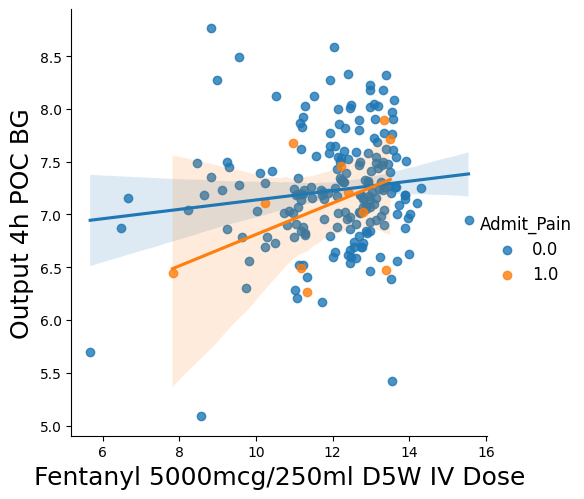

In [343]:
plot=sns.lmplot(x="FENTANYL_CITRATE_IN_D5W_5000_MCG_250_ML__20_MCG_ML__IV_SOLN", y="ORD_VALUE", hue="Admit_Pain", data=df, fit_reg=True)
plt.ylabel("Output 4h POC BG", fontsize=18)
plt.xlabel("Fentanyl 5000mcg/250ml D5W IV Dose", fontsize=18)
legend = plot._legend
legend.set_title(legend.get_title().get_text(), prop={'size': 12})
for text in legend.get_texts():
    text.set_fontsize(12)
plt.savefig('figures/fent_pain.svg', dpi=300)

In [346]:
df=med_lab_static_PMH_admdx_log_nona[['NOREPINEPHRINE__LEVOPHED__0_032MG_ML__8_MG_IN_D5W_250_ML','ORD_VALUE','Admit_Sepsis']]
df=df[df['NOREPINEPHRINE__LEVOPHED__0_032MG_ML__8_MG_IN_D5W_250_ML'] != 0]

In [347]:
df.Admit_Sepsis.value_counts()

0.0    2236
1.0     140
Name: Admit_Sepsis, dtype: int64

In [355]:
1368+294+562+159+145+727+1171

4426

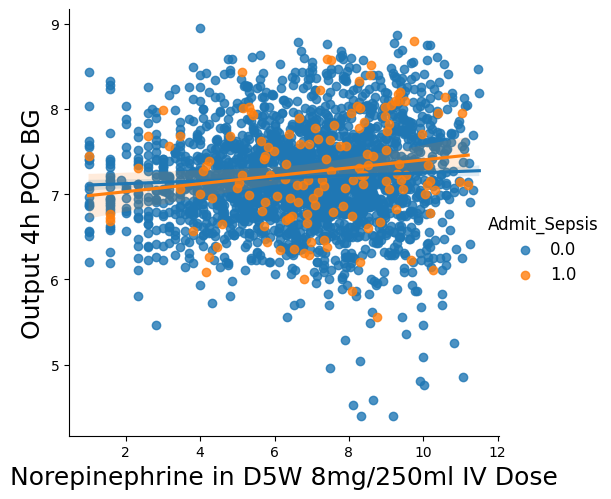

In [348]:
plot=sns.lmplot(x="NOREPINEPHRINE__LEVOPHED__0_032MG_ML__8_MG_IN_D5W_250_ML", y="ORD_VALUE", hue="Admit_Sepsis", data=df, fit_reg=True)
plt.ylabel("Output 4h POC BG", fontsize=18)
plt.xlabel("Norepinephrine in D5W 8mg/250ml IV Dose", fontsize=18)
legend = plot._legend
legend.set_title(legend.get_title().get_text(), prop={'size': 12})
for text in legend.get_texts():
    text.set_fontsize(12)
plt.savefig('figures/norepi_sepsis.svg', dpi=300)

In [349]:
df=med_lab_static_PMH_admdx_log_nona[['KETOROLAC_30_MG_ML__1_ML__IJ_SOLN','ORD_VALUE','Admit_Pain']]
df=df[df['KETOROLAC_30_MG_ML__1_ML__IJ_SOLN'] != 0]

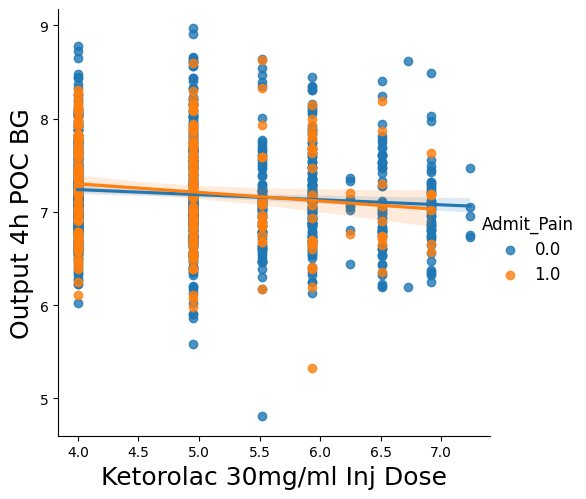

In [350]:
plot=sns.lmplot(x="KETOROLAC_30_MG_ML__1_ML__IJ_SOLN", y="ORD_VALUE", hue="Admit_Pain", data=df, fit_reg=True)
plt.ylabel("Output 4h POC BG", fontsize=18)
plt.xlabel("Ketorolac 30mg/ml Inj Dose", fontsize=18)
legend = plot._legend
legend.set_title(legend.get_title().get_text(), prop={'size': 12})
for text in legend.get_texts():
    text.set_fontsize(12)
plt.savefig('figures/ketoro_pain.svg', dpi=300)

In [351]:
df=med_lab_static_PMH_admdx_log_nona[['RIFAXIMIN_550_MG_PO_TABS','ORD_VALUE','PMH_Liver_failure']]
df=df[df['RIFAXIMIN_550_MG_PO_TABS'] != 0]

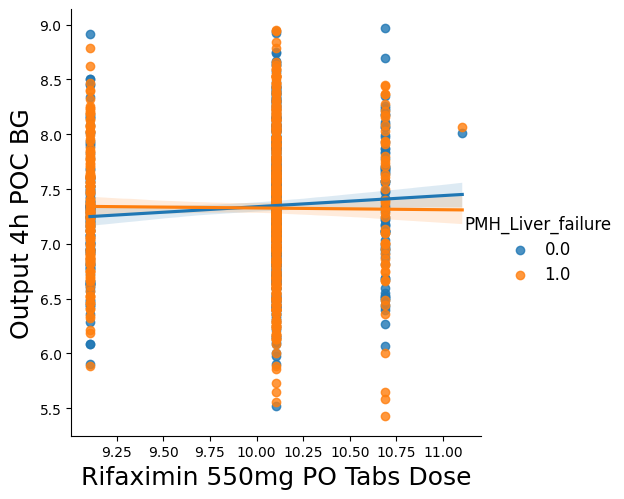

In [352]:
plot=sns.lmplot(x="RIFAXIMIN_550_MG_PO_TABS", y="ORD_VALUE", hue="PMH_Liver_failure", data=df, fit_reg=True)
plt.ylabel("Output 4h POC BG", fontsize=18)
plt.xlabel("Rifaximin 550mg PO Tabs Dose", fontsize=18)
legend = plot._legend
legend.set_title(legend.get_title().get_text(), prop={'size': 12})
for text in legend.get_texts():
    text.set_fontsize(12)
plt.savefig('figures/rifax_liver.svg', dpi=300)